In [2]:
%matplotlib inline
# All required dependencies for all plots 
import aplpy
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from astropy.visualization import simple_norm, AsinhStretch
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
from NOEMAsetup import *
from spectral_cube import SpectralCube
from ChauvenetRMS import *
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.patches import Ellipse, Rectangle
from matplotlib import gridspec
import copy
import pickle
import velocity_tools.stream_lines as SL
from scipy import stats



In [3]:
def plot_aplpy_standard(image, stretch, vmin, vmax, cmap, phasecent=[ra_Per50, dec_Per50], vmid=0.01, figsize=(4,4), label_col='w', star_col='r'):
    fig = aplpy.FITSFigure(image, figsize=figsize)
    if stretch=='arcsinh':
        fig.show_colorscale(stretch=stretch, cmap=cmap, vmin=vmin, vmax=vmax, vmid=vmid)
    else:
        fig.show_colorscale(stretch=stretch, cmap=cmap, vmin=vmin, vmax=vmax)
    fig.add_colorbar()
    setup_plot_noema(fig, label_col=label_col, star_col=star_col)
    fig.beam.set_color('k')
    fig.scalebar.set_linewidth(2)
    return fig
  
def plot_aplpy_subfig(image, figure, subplotindex, stretch, vmin, vmax, cmap, phasecent=[ra_Per50, dec_Per50], vmid=0.01, label_col='w', star_col='r'):
    fig = aplpy.FITSFigure(image, figure=figure, subplot=subplotindex)
    if stretch=='arcsinh':
        fig.show_colorscale(stretch=stretch, cmap=cmap, vmin=vmin, vmax=vmax, vmid=vmid)
    else:
        fig.show_colorscale(stretch=stretch, cmap=cmap, vmin=vmin, vmax=vmax)
    fig.add_colorbar()
    setup_plot_noema(fig, label_col=label_col, star_col=star_col)
    fig.beam.set_color('k')
    fig.scalebar.set_linewidth(2)
    return fig
  
def v_kepler(mass, radius):
    vel = np.sqrt(G * mass / radius)
    return vel

## SO(55-44) plots

### Moment 0

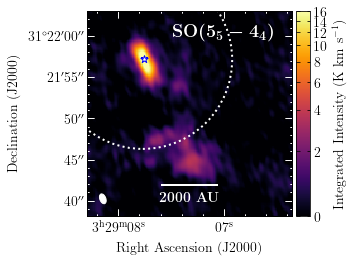

In [3]:
saveaction = 0
folder = 'figures/'
filename = SO_55_44_TdV_s
stretch = 'arcsinh'

# savefile = folder + 'Per-emb-50_SO_55_44_mom0_total_' +stretch + '_continuum.pdf'
savefile = folder + 'Per-emb-50_SO_55_44_mom0_total_' +stretch + '.pdf'
vmin = 0
vmax = 16
vmid = 2
cmap = 'inferno'

headercube = fits.getheader(filename+'.fits')
freq = headercube['RESTFREQ'] * u.Hz
phasecent = [headercube['ra'], headercube['dec']]
title = r'\textbf{SO(\boldmath$5_{5}-4_{4}$)}'

filename_continuum = continuum_selfcal
levels = [0.007]

continuum_header = WCS(fits.getheader(filename_continuum+'.fits')).celestial.to_header()
continuum_data = fits.getdata(filename_continuum+'.fits')[0]
hdu_cont = fits.PrimaryHDU(data=continuum_data, header=continuum_header)

fig = plot_aplpy_standard(filename + '.fits', stretch, vmin, vmax, cmap, label_col='w', star_col='b', vmid=vmid)
fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='w', lw=2)
fig.add_label(0.92,0.9, title, color='w',
               relative=True, horizontalalignment='right', size=18)
fig.scalebar.set_label(r'\textbf{2000 AU}')
# fig.show_contour(hdu_cont, levels=levels, colors='w', linewidths=2, zorder=100)
fig.colorbar.set_axis_label_text(r'Integrated Intensity (K km s$^{-1}$)')
fig.beam.set_frame(False)
fig.beam.set_color('w')
if saveaction:
  plt.savefig(savefile, dpi=300, bbox_inches='tight')

#### SO Position-velocity diagram

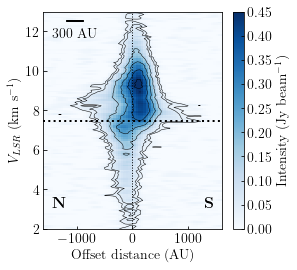

In [6]:
saveaction = 1

pvfile = SO_55_44_PV
savefile = 'figures/PVdiagram_SO_pvline_center_Per50_1arcsec_170PA_12arcsec.pdf'
v_lsr = 7.48*u.km/u.s  # +- 0.14 km/s according to out C18O data
arcsectoau = 293  # * u.au / u.arcsec
pvdata = fits.getdata(pvfile+'.fits')
pvheader = fits.getheader(pvfile+'.fits')
rms = 0.01
contourlevels = np.array([3,5,15,25,35, 45]) * rms
# contourlevels = np.array([3,5]) * rms
vmin = 0
vmax = 0.45

delta0 = pvheader['CRVAL1']
delta_delta = pvheader['CDELT1']
delta_pix0 = pvheader['CRPIX1']
delta_npix = pvheader['NAXIS1']
vel0 = pvheader['CRVAL2']
delta_vel = pvheader['CDELT2']
vel_pix0 = pvheader['CRPIX2']
vel_npix = pvheader['NAXIS2']

delta_array = np.array([delta0 + delta_delta*(i-delta_pix0) for i in range(delta_npix)]) * u.deg
vel_array = np.array([vel0 + delta_vel * (i - vel_pix0) for i in range(vel_npix)]) * u.m/u.s

# transformation to general coordinates
vel_array = vel_array.to(u.km/u.s)
mid_delta = delta_array[int(len(delta_array)/2+2-1)]
offset_array = (delta_array - mid_delta).to(u.arcsec)
distance_array = offset_array.value * arcsectoau * u.au

offset, vel = np.meshgrid(distance_array, vel_array)

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
norm = simple_norm(pvdata, 'linear', min_cut=vmin,max_cut=vmax)
pcolor = ax.pcolor(offset.value, vel.value, pvdata, shading='auto', norm=norm, cmap='Blues')
contours = ax.contour(offset.value, vel.value, pvdata, contourlevels, colors='k', linewidths=0.5)
fig.colorbar(pcolor, ax=ax, label=r'Intensity (Jy beam$^{-1}$)')
    
ax.axhline(v_lsr.value, color='k', linestyle=':', linewidth=2)
ax.axvline(0, color='k', linestyle=':', linewidth=1)
ax.set_ylim([2, 13])
ax.set_ylabel(r'$V_{LSR}$ (km s$^{-1}$)')
ax.set_xlim([-1600, 1600])
ax.set_xlabel('Offset distance (AU)')
ax.annotate(r'\textbf{N}', (0.05, 0.1), xycoords='axes fraction', color='k', size=16)
ax.annotate(r'\textbf{S}', (0.90, 0.1), xycoords='axes fraction', color='k', size=16)

bar = AnchoredSizeBar(ax.transData, 300, '300 AU', 2, pad=0.1, borderpad=0.5, sep=5,  frameon=False, color='k', size_vertical=0.08)
ax.add_artist(bar)

if saveaction:
  plt.savefig(savefile, bbox_inches='tight', dpi=300)

### SO(55-44) 1- and 2-Gaussian fit

### SO with H2CO contours

/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdYlBu_r"))
  cm.set_bad(color)
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


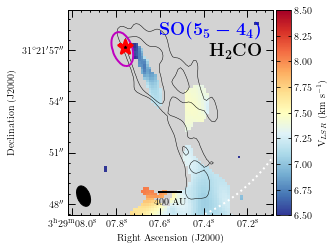

In [4]:
saveaction = 1

filename = 'SO_55_44/CDconfigsmall/Per-emb-50_CD_l009l048_uvsub_SO_multi_small_1G_streamer'
stretch = 'linear'
paramcube = fits.getdata(filename+'.fits')
head = fits.getheader(filename+'.fits')
phasecent = np.array([head['ra'], head['dec']]) * u.deg
freq = head['restfreq'] * u.Hz
header = WCS(head).celestial.to_header()
header['bmaj'] = head['bmaj']
header['bmin'] = head['bmin']
header['bpa'] = head['bpa']
# Here we choose the velocity
moment = paramcube[1]
title_SO = r'\textbf{SO(5\boldmath$_{5}-4_4)$}'
title_H2CO = r'\textbf{H\boldmath$_{2}$CO}'
vmin = 6.5
vmax = 8.5
cmap = 'RdYlBu_r'
ang_size = (400 / 293) * u.arcsec

filename_contour = 'H2CO/CDconfigsmall/Per-emb-50_CD_l021l060_uvsub_H2CO_multi_small_fitcube_stream_mom0'
levels = np.array([3,5]) * 0.25 # K km/s

filename_continuum = 'continuum/Per-emb-50_CD_li_cont_rob1-selfcal'
cont_data = fits.getdata(filename_continuum+'.fits')[0]
cont_header = WCS(fits.getheader(filename_continuum+'.fits')).celestial.to_header()

fig = plot_aplpy_standard(fits.PrimaryHDU(data=moment, header=header), stretch, vmin, vmax, cmap, label_col='k', star_col='r')
fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='w', lw=2)
fig.set_nan_color('lightgrey')
fig.colorbar.set_axis_label_text(r'V$_{LSR}$ (km s$^{-1}$)')
fig.show_contour(filename_contour+'.fits', levels=levels, colors='k', linewidths=0.5)
fig.scalebar.set_length(ang_size)
fig.scalebar.set_label('400 AU')
fig.show_contour(fits.PrimaryHDU(data=cont_data,header=cont_header), levels=[0.007], colors='m', linewidths=2)
fig.recenter(52.2814707, 31.3648160, (6*u.arcsec).to(u.deg).value)
fig._layers['star']._sizes = np.array([200])
fig._layers['star']._linewidths = np.array([3.])
fig.tick_labels.set_xformat('hh:mm:ss.s')
fig.beam.set_frame(False)
fig.add_label(0.95,0.9, title_SO, color='b',
               relative=True, horizontalalignment='right', size=18)
fig.add_label(0.95,0.8, title_H2CO, color='k',
               relative=True, horizontalalignment='right', size=18)
if saveaction:
    savefile = filename + '_v_lsr_H2CO_cont.pdf'
    plt.savefig(savefile, bbox_inches='tight', dpi=300)

### Plot SO different components

/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdYlBu_r"))
  cm.set_bad(color)
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


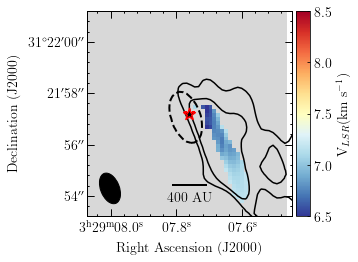

In [4]:
# Streamer component fit
saveaction = 1

filename = SO_55_44_streamer
savefile = 'figures/SO_gaussiancomponents_streamer_v_lsr_H2CO_cont.pdf'
stretch = 'linear'
paramcube = fits.getdata(filename+'.fits')
head = fits.getheader(filename+'.fits')
phasecent = np.array([head['ra'], head['dec']]) *u.deg
freq = head['restfreq'] * u.Hz
header = WCS(head).celestial.to_header()
header['bmaj'] = head['bmaj']
header['bmin'] = head['bmin']
header['bpa'] = head['bpa']
moment = paramcube[1]

vmin = 6.5
vmax = 8.5
cmap = 'RdYlBu_r'
ang_size = (400 / 293) * u.arcsec

filename_contour = 'H2CO/CDconfigsmall/Per-emb-50_CD_l021l060_uvsub_H2CO_multi_small_fitcube_stream_mom0'
levels = np.array([3,5]) * 0.25 # K km/s

filename_continuum = 'continuum/Per-emb-50_CD_li_cont_rob1-selfcal'
cont_data = fits.getdata(filename_continuum+'.fits')[0]
cont_header = WCS(fits.getheader(filename_continuum+'.fits')).celestial.to_header()

fig = plot_aplpy_standard(fits.PrimaryHDU(data=moment, header=header), stretch, vmin, vmax, cmap, label_col='k', star_col='r')
fig.colorbar.set_axis_label_text(r'V$_{LSR}$(km s$^{-1}$)')
fig.colorbar.set_ticks([6.5,7,7.5,8,8.5])
fig.set_nan_color(np.array([1,1,1])*0.85)
fig.show_contour(filename_contour+'.fits', levels=levels, colors='k')
fig.scalebar.set_length(ang_size)
fig.scalebar.set_label('400 AU')
fig.show_contour(fits.PrimaryHDU(data=cont_data,header=cont_header), levels=[0.007], colors='k', linestyles='dashed', linewidths=2)
fig.recenter(ra_Per50.value, dec_Per50.value, (4*u.arcsec).to(u.deg).value)
fig._layers['star']._sizes = np.array([150])
fig._layers['star']._linewidths = np.array([1.5])
fig.tick_labels.set_xformat('hh:mm:ss.s')
fig.beam.set_frame(False)

if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)
  

/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdYlBu_r"))
  cm.set_bad(color)
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


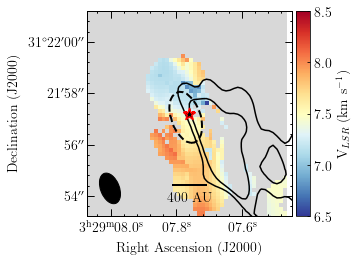

In [6]:
# Rotation component fit
saveaction = 1

filename = SO_55_44_rot
savefile = 'figures/SO_gaussiancomponents_rotation_v_lsr_H2CO_cont.pdf'
stretch = 'linear'
paramcube = fits.getdata(filename+'.fits')
head = fits.getheader(filename+'.fits')
phasecent = np.array([head['ra'], head['dec']]) *u.deg
freq = head['restfreq'] * u.Hz
header = WCS(head).celestial.to_header()
header['bmaj'] = head['bmaj']
header['bmin'] = head['bmin']
header['bpa'] = head['bpa']
moment = paramcube[1]

vmin = 6.5
vmax = 8.5
cmap = 'RdYlBu_r'

filename_contour = 'H2CO/CDconfigsmall/Per-emb-50_CD_l021l060_uvsub_H2CO_multi_small_fitcube_stream_mom0'
levels = np.array([3,5]) * 0.25 # K km/s

ang_size = (400 / 293) * u.arcsec

filename_continuum = 'continuum/Per-emb-50_CD_li_cont_rob1-selfcal'
cont_data = fits.getdata(filename_continuum+'.fits')[0]
cont_header = WCS(fits.getheader(filename_continuum+'.fits')).celestial.to_header()

fig = plot_aplpy_standard(fits.PrimaryHDU(data=moment, header=header), stretch, vmin, vmax, cmap, label_col='k', star_col='r')
fig.colorbar.set_axis_label_text(r'V$_{LSR}$ (km s$^{-1}$)')
fig.colorbar.set_ticks([6.5,7,7.5,8,8.5])
fig.set_nan_color(np.array([1,1,1])*0.85)
fig.scalebar.set_length(ang_size)
fig.scalebar.set_label('400 AU')
fig.show_contour(filename_contour+'.fits', levels=levels, colors='k')
fig.show_contour(fits.PrimaryHDU(data=cont_data,header=cont_header), levels=[0.007], colors='k', linestyles='dashed', linewidths=2)
fig.recenter(ra_Per50.value, dec_Per50.value, (4*u.arcsec).to(u.deg).value)
fig._layers['star']._sizes = np.array([150])
fig._layers['star']._linewidths = np.array([1.5])
fig.tick_labels.set_xformat('hh:mm:ss.s')
fig.beam.set_frame(False)

if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)

/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdYlBu_r"))
  cm.set_bad(color)
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


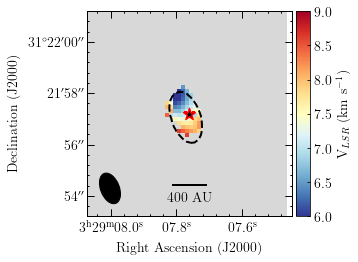

In [9]:
# Wing component
saveaction = 1

filename = SO_55_44_disk
savefile = 'figures/SO_gaussiancomponents_disk_v_lsr_H2CO_cont.pdf'
stretch = 'linear'
paramcube = fits.getdata(filename+'.fits')
head = fits.getheader(filename+'.fits')
phasecent = np.array([head['ra'], head['dec']]) *u.deg
freq = head['restfreq'] * u.Hz
header = WCS(head).celestial.to_header()
header['bmaj'] = head['bmaj']
header['bmin'] = head['bmin']
header['bpa'] = head['bpa']
moment = paramcube[1]

vmin = 6
vmax = 9
cmap = 'RdYlBu_r'

ang_size = (400 / 293) * u.arcsec

filename_continuum = 'continuum/Per-emb-50_CD_li_cont_rob1-selfcal'
cont_data = fits.getdata(filename_continuum+'.fits')[0]
cont_header = WCS(fits.getheader(filename_continuum+'.fits')).celestial.to_header()

fig = plot_aplpy_standard(fits.PrimaryHDU(data=moment, header=header), stretch, vmin, vmax, cmap, label_col='k', star_col='r')
fig.colorbar.set_axis_label_text(r'V$_{LSR}$ (km s$^{-1}$)')
fig.set_nan_color(np.array([1,1,1])*0.85)
fig.scalebar.set_length(ang_size)
fig.scalebar.set_label('400 AU')
fig.show_contour(fits.PrimaryHDU(data=cont_data,header=cont_header), levels=[0.007], colors='k', linestyles='dashed', linewidths=2)
fig.recenter(ra_Per50.value, dec_Per50.value, (4*u.arcsec).to(u.deg).value)
fig._layers['star']._sizes = np.array([150])
fig._layers['star']._linewidths = np.array([1.5])
fig.tick_labels.set_xformat('hh:mm:ss.s')
fig.beam.set_frame(False)
# if we want to show the outflow direction
# xx = 52.2823333
# yy = 31.3658889
# dx = 52.2830944 - xx
# dy = 31.36591 - yy
# fig.show_arrows(xx, yy, dx, dy, color='r')
# fig.show_arrows(xx, yy, -dx, -dy, color='b')

if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)

/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdYlBu_r"))
  cm.set_bad(color)
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


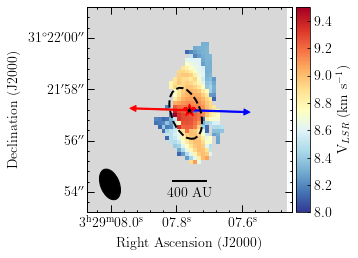

In [14]:
# What is left: infall or outflow? or both?
saveaction = 1

filename = SO_55_44_infall
savefile = 'figures/SO_gaussiancomponents_infall_v_lsr.pdf'
stretch = 'linear'
paramcube = fits.getdata(filename+'.fits')
head = fits.getheader(filename+'.fits')
phasecent = np.array([head['ra'], head['dec']]) *u.deg
freq = head['restfreq'] * u.Hz
header = WCS(head).celestial.to_header()
header['bmaj'] = head['bmaj']
header['bmin'] = head['bmin']
header['bpa'] = head['bpa']
moment = paramcube[1]

vmin = 8
vmax = 9.5
cmap = 'RdYlBu_r'
xx = 52.2823333
yy = 31.3658889
dx = 52.2830944 - xx
dy = 31.36591 - yy
ang_size = (400 / 293) * u.arcsec

filename_continuum = 'continuum/Per-emb-50_CD_li_cont_rob1-selfcal'
cont_data = fits.getdata(filename_continuum+'.fits')[0]
cont_header = WCS(fits.getheader(filename_continuum+'.fits')).celestial.to_header()

fig = plot_aplpy_standard(fits.PrimaryHDU(data=moment, header=header), stretch, vmin, vmax, cmap, label_col='k', star_col='r')
fig.colorbar.set_axis_label_text(r'V$_{LSR}$ (km s$^{-1}$)')
fig.set_nan_color(np.array([1,1,1])*0.85)
fig.scalebar.set_length(ang_size)
fig.scalebar.set_label('400 AU')
fig.show_contour(fits.PrimaryHDU(data=cont_data,header=cont_header), levels=[0.007], colors='k', linestyles='dashed', linewidths=2)
fig.recenter(ra_Per50.value, dec_Per50.value, (4*u.arcsec).to(u.deg).value)
fig._layers['star']._sizes = np.array([150])
fig._layers['star']._linewidths = np.array([1.5])
fig.tick_labels.set_xformat('hh:mm:ss.s')
fig.beam.set_frame(False)
# we want to show the outflow direction
fig.show_arrows(xx, yy, dx, dy, color='r')
fig.show_arrows(xx, yy, -dx, -dy, color='b')

if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)

### Plot of each component with parameters (for appendix)

/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdYlBu_r"))
  cm.set_bad(color)
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap

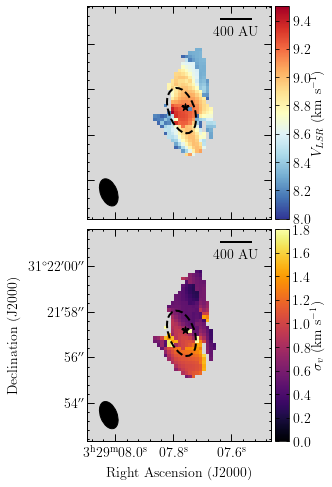

In [24]:
# Infall (?)
saveaction = 1

filename = SO_55_44_infall
savefile = 'figures/SO_parameters_infall_a_v_sigma.pdf'
stretch = 'linear'
cmap = ['RdYlBu_r', 'inferno']
paramcube = fits.getdata(filename+'.fits')
head = fits.getheader(filename+'.fits')
phasecent = np.array([head['ra'], head['dec']]) *u.deg
freq = head['restfreq'] * u.Hz
header = WCS(head).celestial.to_header()
header['bmaj'] = head['bmaj']
header['bmin'] = head['bmin']
header['bpa'] = head['bpa']

filename_continuum = 'continuum/Per-emb-50_CD_li_cont_rob1-selfcal'
cont_data = fits.getdata(filename_continuum+'.fits')[0]
cont_header = WCS(fits.getheader(filename_continuum+'.fits')).celestial.to_header()

vmin = [8, 0.]
vmax = [9.5, 1.8]
ang_size = (400 / 293) * u.arcsec
colorbarlabel = [r'$V_{LSR}$ (km s$^{-1}$)', r'$\sigma_v$ (km s$^{-1}$)']

fig = plt.figure(figsize=(4,8))
for i in range(1,3):
    component1 = fits.PrimaryHDU(data=paramcube[i],header=header)
    gc1 = plot_aplpy_subfig(component1, fig, (2,1,i), stretch, vmin[i-1], vmax[i-1], cmap[i-1], label_col='k', star_col='k')
    gc1.set_nan_color(np.array([1,1,1])*0.85)
    gc1.show_contour(fits.PrimaryHDU(data=cont_data,header=cont_header), levels=[0.007], colors='k', linestyles='dashed', linewidths=2)
    gc1.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls='--', color='w', lw=2)
    gc1.scalebar.set_corner('top right')
    gc1.scalebar.set_length(ang_size)
    gc1.scalebar.set_label('400 AU')
    gc1.colorbar.set_axis_label_text(colorbarlabel[i-1])
    gc1.colorbar.set_axis_label_pad(0.0)
    gc1.tick_labels.set_xformat('hh:mm:ss.s')
    gc1.beam.set_frame(False)

    if i==1:
        gc1.tick_labels.hide()
        gc1.axis_labels.hide()
#         gc1.colorbar.set_ticks([6.5, 7,7.5,8,8.5])
#     if i==2:
# #         gc1.colorbar.set_ticks([0,0.15,0.3,0.45,0.6,0.75])
fig.subplots_adjust(hspace=0.05)

if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)


/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdYlBu_r"))
  cm.set_bad(color)
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap

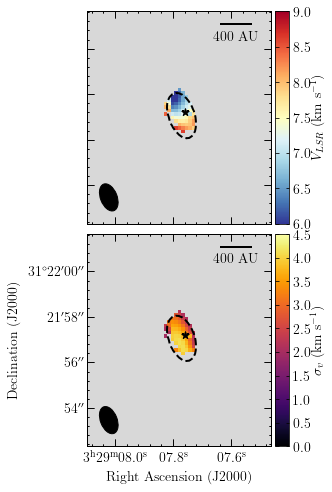

In [26]:
# Wings: disk
saveaction = 1

filename = SO_55_44_disk
savefile = 'figures/SO_parameters_disk_a_v_sigma.pdf'
stretch = 'linear'
cmap = ['RdYlBu_r', 'inferno']
paramcube = fits.getdata(filename+'.fits')
head = fits.getheader(filename+'.fits')
phasecent = np.array([head['ra'], head['dec']]) *u.deg
freq = head['restfreq'] * u.Hz
header = WCS(head).celestial.to_header()
header['bmaj'] = head['bmaj']
header['bmin'] = head['bmin']
header['bpa'] = head['bpa']

filename_continuum = 'continuum/Per-emb-50_CD_li_cont_rob1-selfcal'
cont_data = fits.getdata(filename_continuum+'.fits')[0]
cont_header = WCS(fits.getheader(filename_continuum+'.fits')).celestial.to_header()

vmin = [6, 0.]
vmax = [9, 4.5]
ang_size = (400 / 293) * u.arcsec
colorbarlabel = [r'$V_{LSR}$ (km s$^{-1}$)', r'$\sigma_v$ (km s$^{-1}$)']

fig = plt.figure(figsize=(4,8))
for i in range(1,3):
    component1 = fits.PrimaryHDU(data=paramcube[i],header=header)
    gc1 = plot_aplpy_subfig(component1, fig, (2,1,i), stretch, vmin[i-1], vmax[i-1], cmap[i-1], label_col='k', star_col='k')
    gc1.set_nan_color(np.array([1,1,1])*0.85)
    gc1.show_contour(fits.PrimaryHDU(data=cont_data,header=cont_header), levels=[0.007], colors='k', linestyles='dashed', linewidths=2)
    gc1.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls='--', color='w', lw=2)
    gc1.scalebar.set_corner('top right')
    gc1.scalebar.set_length(ang_size)
    gc1.scalebar.set_label('400 AU')
    gc1.colorbar.set_axis_label_text(colorbarlabel[i-1])
    gc1.colorbar.set_axis_label_pad(0.0)
    gc1.tick_labels.set_xformat('hh:mm:ss.s')
    gc1.beam.set_frame(False)

    if i==1:
        gc1.tick_labels.hide()
        gc1.axis_labels.hide()
#         gc1.colorbar.set_ticks([6.5, 7,7.5,8,8.5])
#     if i==2:
# #         gc1.colorbar.set_ticks([0,0.15,0.3,0.45,0.6,0.75])
fig.subplots_adjust(hspace=0.05)

if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)

/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdYlBu_r"))
  cm.set_bad(color)
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap

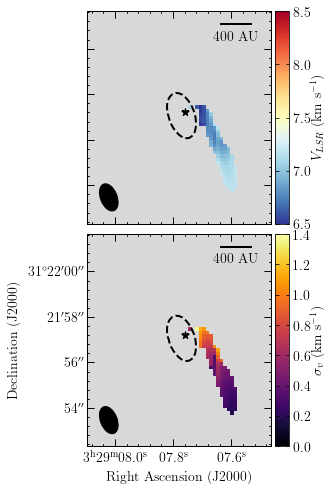

In [29]:
# streamer
saveaction = 1

filename = SO_55_44_streamer
savefile = 'figures/SO_parameters_streamer_a_v_sigma.pdf'
stretch = 'linear'
cmap = ['RdYlBu_r', 'inferno']
paramcube = fits.getdata(filename+'.fits')
head = fits.getheader(filename+'.fits')
phasecent = np.array([head['ra'], head['dec']]) *u.deg
freq = head['restfreq'] * u.Hz
header = WCS(head).celestial.to_header()
header['bmaj'] = head['bmaj']
header['bmin'] = head['bmin']
header['bpa'] = head['bpa']

filename_continuum = 'continuum/Per-emb-50_CD_li_cont_rob1-selfcal'
cont_data = fits.getdata(filename_continuum+'.fits')[0]
cont_header = WCS(fits.getheader(filename_continuum+'.fits')).celestial.to_header()

vmin = [6.5, 0.]
vmax = [8.5, 1.4]
ang_size = (400 / 293) * u.arcsec
colorbarlabel = [r'$V_{LSR}$ (km s$^{-1}$)', r'$\sigma_v$ (km s$^{-1}$)']

fig = plt.figure(figsize=(4,8))
for i in range(1,3):
    component1 = fits.PrimaryHDU(data=paramcube[i],header=header)
    gc1 = plot_aplpy_subfig(component1, fig, (2,1,i), stretch, vmin[i-1], vmax[i-1], cmap[i-1], label_col='k', star_col='k')
    gc1.set_nan_color(np.array([1,1,1])*0.85)
    gc1.show_contour(fits.PrimaryHDU(data=cont_data,header=cont_header), levels=[0.007], colors='k', linestyles='dashed', linewidths=2)
    gc1.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls='--', color='w', lw=2)
    gc1.scalebar.set_corner('top right')
    gc1.scalebar.set_length(ang_size)
    gc1.scalebar.set_label('400 AU')
    gc1.colorbar.set_axis_label_text(colorbarlabel[i-1])
    gc1.colorbar.set_axis_label_pad(0.0)
    gc1.tick_labels.set_xformat('hh:mm:ss.s')
    gc1.beam.set_frame(False)

    if i==1:
        gc1.tick_labels.hide()
        gc1.axis_labels.hide()
        gc1.colorbar.set_ticks([6.5, 7,7.5,8,8.5])
#     if i==2:
# #         gc1.colorbar.set_ticks([0,0.15,0.3,0.45,0.6,0.75])
fig.subplots_adjust(hspace=0.05)

if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)

/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdYlBu_r"))
  cm.set_bad(color)
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap

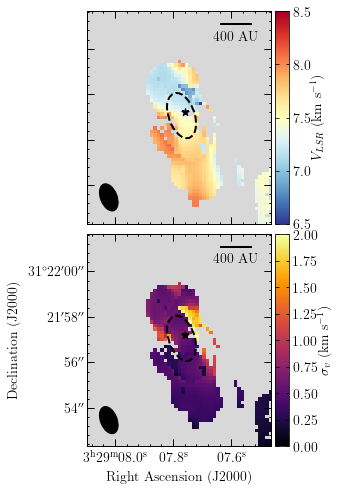

In [31]:
# Rotation
saveaction = 1

filename = SO_55_44_rot
savefile = 'figures/SO_parameters_rotation_a_v_sigma.pdf'
stretch = 'linear'
cmap = ['RdYlBu_r', 'inferno']
paramcube = fits.getdata(filename+'.fits')
head = fits.getheader(filename+'.fits')
phasecent = np.array([head['ra'], head['dec']]) *u.deg
freq = head['restfreq'] * u.Hz
header = WCS(head).celestial.to_header()
header['bmaj'] = head['bmaj']
header['bmin'] = head['bmin']
header['bpa'] = head['bpa']

filename_continuum = 'continuum/Per-emb-50_CD_li_cont_rob1-selfcal'
cont_data = fits.getdata(filename_continuum+'.fits')[0]
cont_header = WCS(fits.getheader(filename_continuum+'.fits')).celestial.to_header()

vmin = [6.5, 0.]
vmax = [8.5, 2]
ang_size = (400 / 293) * u.arcsec
colorbarlabel = [r'$V_{LSR}$ (km s$^{-1}$)', r'$\sigma_v$ (km s$^{-1}$)']

fig = plt.figure(figsize=(4,8))
for i in range(1,3):
    component1 = fits.PrimaryHDU(data=paramcube[i],header=header)
    gc1 = plot_aplpy_subfig(component1, fig, (2,1,i), stretch, vmin[i-1], vmax[i-1], cmap[i-1], label_col='k', star_col='k')
    gc1.set_nan_color(np.array([1,1,1])*0.85)
    gc1.show_contour(fits.PrimaryHDU(data=cont_data,header=cont_header), levels=[0.007], colors='k', linestyles='dashed', linewidths=2)
    gc1.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls='--', color='w', lw=2)
    gc1.scalebar.set_corner('top right')
    gc1.scalebar.set_length(ang_size)
    gc1.scalebar.set_label('400 AU')
    gc1.colorbar.set_axis_label_text(colorbarlabel[i-1])
    gc1.colorbar.set_axis_label_pad(0.0)
    gc1.tick_labels.set_xformat('hh:mm:ss.s')
    gc1.beam.set_frame(False)

    if i==1:
        gc1.tick_labels.hide()
        gc1.axis_labels.hide()
        gc1.colorbar.set_ticks([6.5, 7,7.5,8,8.5])
#     if i==2:
# #         gc1.colorbar.set_ticks([0,0.15,0.3,0.45,0.6,0.75])
fig.subplots_adjust(hspace=0.05)

if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)

#### Plot delta v of SO streamer component and H2CO streamer component

/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdYlBu_r"))
  cm.set_bad(color)
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


0.36768418399107716


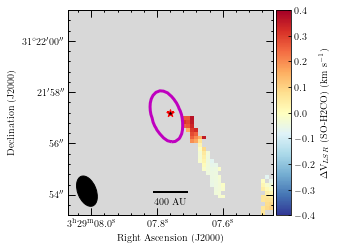

In [26]:
saveaction = 1

filename_H2CO = H2CO_303_202_fit_Vc
filename_SO = 'SO_55_44/CDconfigsmall/Per-emb-50_CD_l009l048_uvsub_SO_multi_small_1G_streamer_reprojectH2COsmall'
savefile = 'SO_55_44/CDconfigsmall/difference_vlsr_H2CO_SO.pdf'
H2CO_data = fits.getdata(filename_H2CO+'.fits')
SO_data = fits.getdata(filename_SO+'.fits')
header = fits.getheader(filename_H2CO+'.fits')
phasecent = np.array([header['ra'], header['dec']]) *u.deg
freq = header['restfreq'] * u.Hz

vmin = -0.4
vmax = 0.4
cmap = 'RdYlBu_r'

filename_continuum = 'continuum/Per-emb-50_CD_li_cont_rob1-selfcal'
cont_data = fits.getdata(filename_continuum+'.fits')[0]
cont_header = WCS(fits.getheader(filename_continuum+'.fits')).celestial.to_header()

ang_size = (400 / 293) * u.arcsec

fig = plot_aplpy_standard(fits.PrimaryHDU(data=SO_data-H2CO_data, header=header), stretch, vmin, vmax, cmap, label_col='k', star_col='r')
fig.colorbar.set_axis_label_text(r'$\Delta$V$_{LSR}$ (SO-H2CO) (km s$^{-1}$)')
fig.recenter(ra_Per50.value, dec_Per50.value, (4*u.arcsec).to(u.deg).value)
fig.set_nan_color(np.array([1,1,1])*0.85)
fig.show_contour(fits.PrimaryHDU(data=cont_data,header=cont_header), levels=[0.007], colors='m', linewidths=3)
fig.scalebar.set_length(ang_size)
fig.scalebar.set_label('400 AU')
fig.tick_labels.set_xformat('hh:mm:ss.s')
fig.beam.set_frame(False)
print(np.nanmax(SO_data-H2CO_data))

if saveaction:
  plt.savefig(savefile, bbox_inches='tight', dpi=300)

### SO with H2CO and C18O spectra at the kink

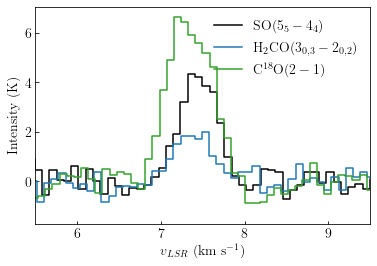

In [12]:
saveaction = 1
folder = 'SO_55_44/CDconfig/'
filename = folder+'Per-emb-50_CD_l009l048_uvsub_SO_multi_pbcor'
cube = SpectralCube.read(filename+'.fits').with_spectral_unit(u.km/u.s).to(u.K)
wcscel = cube.wcs.celestial
x, y = wcscel.all_world2pix([52.2810100],[31.3649452],0)
spectra = cube[:,int(y[0]),int(x[0])]
vel = cube.spectral_axis.value

savefile = filename+'_sample_spectra_kink.pdf'

filename_H2CO = 'H2CO/CDconfig/Per-emb-50_CD_l021l060_uvsub_H2CO_multi_pbcor'
filename_C18O = 'C18O/CDconfig/JEP/JEP_mask_multi_Per-emb-50_CD_l025l064_uvsub_C18O_pbcor'
cubeH2CO = SpectralCube.read(filename_H2CO+'.fits').with_spectral_unit(u.km/u.s).to(u.K)
wcscel = cubeH2CO.wcs.celestial
x, y = wcscel.all_world2pix([52.2810100],[31.3649452],0)
spectraH2CO = cubeH2CO[:,int(y[0]),int(x[0])]
velH2CO = cubeH2CO.spectral_axis.value

cubeC18O = SpectralCube.read(filename_C18O+'.fits').with_spectral_unit(u.km/u.s).to(u.K)
wcscel = cubeC18O.wcs.celestial
x, y = wcscel.all_world2pix([52.2810100],[31.3649452],0)
spectraC18O = cubeC18O[:,int(y[0]),int(x[0])]
velC18O = cubeC18O.spectral_axis.value

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.plot(vel,spectra,drawstyle='steps-mid', color='k', label=r'SO($5_5-4_4$)')
ax.plot(velH2CO,spectraH2CO,drawstyle='steps-mid', color='#1f78b4', label=r'H$_2$CO($3_{0,3}-2_{0,2}$)')
ax.plot(velC18O,spectraC18O,drawstyle='steps-mid', color='#33a02c', label=r'C$^{18}$O($2-1$)')
ax.set_xlabel(r'$v_{LSR}$ (km s$^{-1}$)')
ax.set_ylabel(r'Intensity (K)')
ax.set_xlim([5.5,9.5])
ax.legend(frameon=False)
# ax.annotate(r'\textbf{H\boldmath$_{2}$CO($3_{0,3}-2_{0,2}$)}',(0.6,0.9), xycoords='axes fraction', color='k', size=14)

if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)

## H2CO Plots

### Moment 0

/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


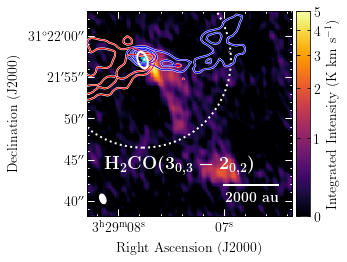

In [16]:
saveaction = 1

folder = 'figures/'
filename = H2CO_303_202_TdV_s
cleanalg = 'Multi'
stretch = 'arcsinh'

filename_continuum = continuum_selfcal
levels = [0.007]

continuum_header = WCS(fits.getheader(filename_continuum+'.fits')).celestial.to_header()
continuum_data = fits.getdata(filename_continuum+'.fits')[0]
hdu_cont = fits.PrimaryHDU(data=continuum_data, header=continuum_header)

savefile = folder + 'H2CO_'+cleanalg+'_fitcube_total_mom0_labeled_continuum' + stretch + '_withoutflow.pdf'
vmin = 0
vmax = 5
vmid = 1
cmap = 'inferno'
title = r'\textbf{H\boldmath$_{2}$CO($3_{0,3}-2_{0,2}$)}'

contourblue = CO21blue
contourred = CO21red
levelblue = np.mgrid[0.58:2:0.5]
levelred = np.mgrid[0.58:2:1]

contourbluedata = fits.getdata(CO21blue+'.fits')
contourbluedata[:80] = np.nan
contourbluehead = fits.getheader(CO21blue+'.fits')
contourreddata = fits.getdata(CO21red+'.fits')
contourreddata[:,120:] = np.nan
contourredhead = fits.getheader(CO21red+'.fits')

headercube = fits.getheader(filename+'.fits')
freq = headercube['RESTFREQ'] * u.Hz
phasecent = [headercube['ra'], headercube['dec']]

fig = plot_aplpy_standard(filename+'.fits', stretch, vmin, vmax, cmap, label_col='w', star_col='c', vmid=vmid)
fig.colorbar.set_axis_label_text(r'Integrated Intensity (K km s$^{-1}$)')
fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='w', lw=2)
fig.scalebar.set_corner('bottom right')
fig.scalebar.set_label(r'\textbf{2000 au}')
fig.add_label(0.82,0.25, title, color='w',
               relative=True, horizontalalignment='right', size=18)
fig.show_contour(hdu_cont, levels=levels, colors='w', linewidths=2, zorder=100)
# fig.show_contour(contourblue+'.fits', levels=levelblue, colors='b', linewidths = 1, zorder=21)
fig.show_contour(fits.PrimaryHDU(contourbluedata, contourbluehead), levels=levelblue, colors='b', linewidths = 1, zorder=21)
fig.show_contour(fits.PrimaryHDU(contourreddata, contourredhead), levels=levelred, colors='r', linewidths = 1, zorder=21)
fig.show_contour(fits.PrimaryHDU(contourbluedata, contourbluehead), levels=levelblue, colors='w', linewidths = 2, zorder=11)
fig.show_contour(fits.PrimaryHDU(contourreddata, contourredhead), levels=levelred, colors='w', linewidths = 2, zorder=11)
fig.beam.set_frame(False)
fig.beam.set_color('w')
if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)


## Noise plots


### H2CO

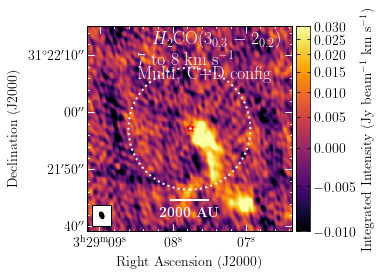

In [3]:
saveaction = 0
contourplot = 0
regionplot = 0

folder = 'H2CO/CDconfig/'
filename = H2CO_303_202
cleanalg = 'Multi, C+D config'
stretch = 'arcsinh'
moment = 0
velinit = 7 #km/s
velend = 8 #km/s
savefile = folder + 'H2CO_'+cleanalg+'_'+str(velinit)+'to'+str(velend)+'_'+stretch+'_moment'+str(moment)+'.pdf'
vmin = -0.01
vmax = 0.03
vmid = 0.001
cmap = 'inferno'
radiusplot = 18/3600
title = r'$H_{2}$CO($3_{0,3}-2_{0,2}$)\\'+str(velinit)+' to '+str(velend)+r' km s$^{-1}$\\'+cleanalg

contourfile = 'SO_55_44/Per-emb-50_C_l009l048_cont.fits'
contourfile2 = filename+'.fits'
contlevels = [0.007]
regions = folder +'spectra_regs.reg'

cube = SpectralCube.read(filename+'.fits')
cube = cube.with_spectral_unit(u.km/u.s)
headercube = cube.hdu.header
freq = headercube['RESTFREQ'] * u.Hz
phasecent = [headercube['ra'], headercube['dec']]

subcube = cube.spectral_slab(velinit*u.km/u.s, velend*u.km/u.s)
moment = subcube.moment(order=moment).hdu
rms = calculatenoise(moment.data)[0]
if contourplot:
    contourfile = SpectralCube.read(contourfile)
    contourfile = contourfile[0,:,:]
    contourfile2 = SpectralCube.read(contourfile2).with_spectral_unit(u.km/u.s)
    contour2 = contourfile2.spectral_slab(velinit*u.km/u.s, velend*u.km/u.s).moment(order=moment).hdu
    rms2 = calculatenoise(contour2.data)[0]


fig = plot_aplpy_standard(moment, stretch, vmin, vmax, cmap, vmid=vmid)
fig.recenter(phasecent[0], phasecent[1], radiusplot)
fig.colorbar.set_axis_label_text(r'Integrated Intensity (Jy beam$^{-1}$ km s$^{-1}$)')
fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='w', lw=2)
if contourplot:
    fig.show_contour(contour2, levels=[rms2*3, rms2*5], colors='w')
if regionplot:
    fig.show_regions(regions)
fig.add_label(0.95,0.85, title, color='white',
               relative=True, horizontalalignment='right', size=18)
fig.scalebar.set_label(r'\textbf{2000 AU}')

if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)


### Gaussian Fit result plots

#### H2CO fit results

/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdYlBu_r"))
  cm.set_bad(color)


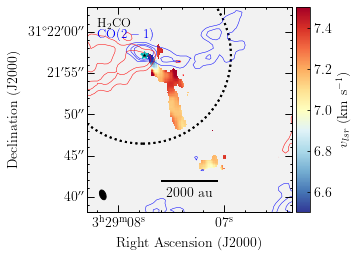

In [3]:
# Just the H2CO velocity component
saveaction = 1

filename = H2CO_303_202_s + '_1G_fitparams'
stretch = 'linear'
paramcube = fits.getdata(filename+'.fits')
head = fits.getheader(filename+'.fits')
phasecent = np.array([head['ra'], head['dec']]) *u.deg
freq = head['restfreq'] * u.Hz
header = WCS(head).celestial.to_header()
header['bmaj'] = head['bmaj']
header['bmin'] = head['bmin']
header['bpa'] = head['bpa']
velocity = paramcube[1]
vmin = 6.5
vmax = 7.5
cmap = 'RdYlBu_r'
nancolor = np.array([1,1,1])*0.95

contourblue = CO21blue
contourred = CO21red
levelblue = np.mgrid[0.58:2:0.5]
levelred = np.mgrid[0.58:2:1]


savefile = filename + '_v_lsr_6.5_7.5_withoutflow.pdf'

fig = plot_aplpy_standard(fits.PrimaryHDU(data=velocity, header=header), stretch, vmin, vmax, cmap, label_col='k', star_col='c')
fig.colorbar.set_axis_label_text(r'$v_{lsr}$ (km s$^{-1}$)')
fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='k', lw=2)
fig.set_nan_color(nancolor)
fig.beam.set_frame(False)
fig.show_contour(contourblue+'.fits', levels=levelblue, colors='b', linewidths = 0.5)
fig.show_contour(contourred+'.fits', levels=levelred, colors='r', linewidths = 0.5)
fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='k', lw=2)
fig.add_label(0.05,0.92, r'H$_{2}$CO', color='k',
               relative=True, horizontalalignment='left', size=13)
fig.add_label(0.05,0.86, r'CO($2-1$)', color='b',
               relative=True, horizontalalignment='left', size=13)
if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)


#### Velocity and sigma together with integrated intensity

/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdYlBu_r"))
  cm.set_bad(color)
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap

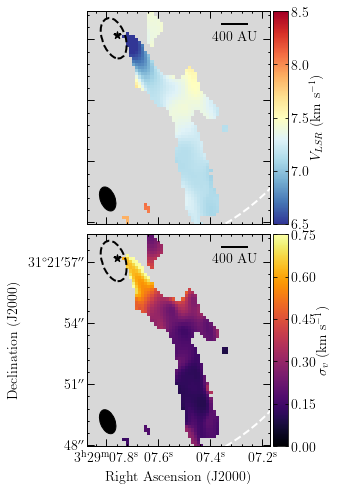

In [21]:
saveaction = 1

folder = 'figures/'
filename = H2CO_303_202_fitparams
savefile = folder + 'H2CO_fitresults_v_sigmav.pdf'
stretch = 'linear'
cmap = ['RdYlBu_r', 'inferno']
paramcube = fits.getdata(filename+'.fits')
head = fits.getheader(filename+'.fits')
phasecent = np.array([head['ra'], head['dec']]) *u.deg
freq = head['restfreq'] * u.Hz
header = WCS(head).celestial.to_header()
header['bmaj'] = head['bmaj']
header['bmin'] = head['bmin']
header['bpa'] = head['bpa']

filename_continuum = continuum_selfcal
cont_data = fits.getdata(filename_continuum+'.fits')[0]
cont_header = WCS(fits.getheader(filename_continuum+'.fits')).celestial.to_header()

vmin = [6.5, 0.]
vmax = [8.5, 0.75]
ang_size = (400 / 293) * u.arcsec
colorbarlabel = ['Peak intensity (K)', r'$V_{LSR}$ (km s$^{-1}$)', r'$\sigma_v$ (km s$^{-1}$)']

fig = plt.figure(figsize=(4,8))
for i in range(1,3):
  component1 = fits.PrimaryHDU(data=paramcube[i],header=header)
  gc1 = plot_aplpy_subfig(component1, fig, (2,1,i), stretch, vmin[i-1], vmax[i-1], cmap[i-1], label_col='k', star_col='k')
  gc1.set_nan_color(np.array([1,1,1])*0.85)
  gc1.show_contour(fits.PrimaryHDU(data=cont_data,header=cont_header), levels=[0.007], colors='k', linestyles='dashed', linewidths=2)
  gc1.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls='--', color='w', lw=2)
  gc1.scalebar.set_corner('top right')
  gc1.scalebar.set_length(ang_size)
  gc1.scalebar.set_label('400 AU')
  gc1.colorbar.set_axis_label_text(colorbarlabel[i])
  gc1.colorbar.set_axis_label_pad(0.0)
  gc1.tick_labels.set_xformat('hh:mm:ss.s')
  gc1.beam.set_frame(False)
  gc1.recenter(52.2813459,31.3647663, width=0.0025, height=0.0029)
  if i==1:
    gc1.tick_labels.hide()
    gc1.axis_labels.hide()
    gc1.colorbar.set_ticks([6.5, 7,7.5,8,8.5])
  if i==2:
    gc1.colorbar.set_ticks([0,0.15,0.3,0.45,0.6,0.75])
fig.subplots_adjust(hspace=0.05)
if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)

### H2CO zoom into gradient with H2CO contours

/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdYlBu_r"))
  cm.set_bad(color)
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


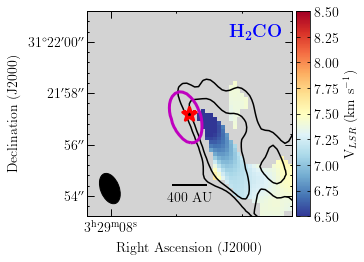

In [10]:
saveaction = 1

filename = H2CO_303_202_s + '_1G_fitparams'
stretch = 'linear'
paramcube = fits.getdata(filename+'.fits')
head = fits.getheader(filename+'.fits')
phasecent = np.array([head['ra'], head['dec']]) *u.deg
freq = head['restfreq'] * u.Hz
header = WCS(head).celestial.to_header()
header['bmaj'] = head['bmaj']
header['bmin'] = head['bmin']
header['bpa'] = head['bpa']
moment = paramcube[1]
vmin = 6.5
vmax = 8.5
cmap = 'RdYlBu_r'

ang_size = (400 / 293) * u.arcsec
title = r'\textbf{H\boldmath$_{2}$CO}'
filename_contour = 'H2CO/CDconfigsmall/Per-emb-50_CD_l021l060_uvsub_H2CO_multi_small_fitcube_stream_mom0'
levels = np.array([3,5]) * 0.25 # K km/s

filename_continuum = 'continuum/Per-emb-50_CD_li_cont_rob1-selfcal'
cont_data = fits.getdata(filename_continuum+'.fits')[0]
cont_header = WCS(fits.getheader(filename_continuum+'.fits')).celestial.to_header()

fig = plot_aplpy_standard(fits.PrimaryHDU(data=moment, header=header), stretch, vmin, vmax, cmap, label_col='k', star_col='r')
fig.set_nan_color('lightgrey')
fig.colorbar.set_axis_label_text(r'V$_{LSR}$ (km s$^{-1}$)')
fig.show_contour(filename_contour+'.fits', levels=levels, colors='k')
fig.scalebar.set_length(ang_size)
fig.scalebar.set_label('400 AU')
fig.show_contour(fits.PrimaryHDU(data=cont_data,header=cont_header), levels=[0.007], colors='m', linewidths=3)
fig.recenter(ra_Per50.value, dec_Per50.value, (4*u.arcsec).to(u.deg).value)
fig._layers['star']._sizes = np.array([200])
fig._layers['star']._linewidths = np.array([3.])
fig.beam.set_frame(False)
fig.add_label(0.95,0.9, title, color='b',
               relative=True, horizontalalignment='right', size=18)
if saveaction:
    savefile = filename + '_v_lsr_H2CO_cont.pdf'
    plt.savefig(savefile, bbox_inches='tight', dpi=300)
  


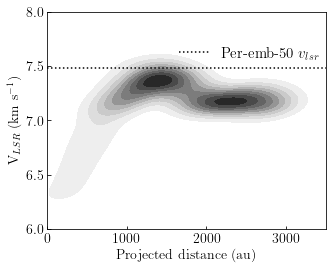

In [65]:
# Plot the velocity plane of the fitted values
saveaction = 1
filename = H2CO_303_202_fit_Vc
savefile = filename + '_vel_kde.pdf'
regionfile = 'data/region_streamer_l_kink.reg'
r_proj, v_los = per_emb_50_get_vc_r(filename+'.fits', regionfile)

# create the grid for the kernel distribution
xmin = 0
xmax = 3500
ymin = 6.
ymax = 8.
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
#
gd_vlos = np.isfinite(r_proj*v_los)  # filter nan
values = np.vstack([r_proj[gd_vlos].value, v_los[gd_vlos].value])

kernel = stats.gaussian_kde(values)
zz = np.reshape(kernel(positions).T, xx.shape)
zz /= zz.max()  # normalization of probability

fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111)
ax.set_xlabel('Projected distance (au)')
ax.set_ylabel(r"V$_{LSR}$ (km s$^{-1}$)")
ax.contourf(xx, yy, zz, cmap='Greys', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax.set_ylim([6,8])
ax.set_xlim([0, 3500])
ax.axhline(v_lsr.value, color='k', label=r'Per-emb-50 $v_{lsr}$', ls=':')
ax.legend(loc=(0.45, 0.75), frameon=False, fontsize=15)
if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)

H2Co pretty

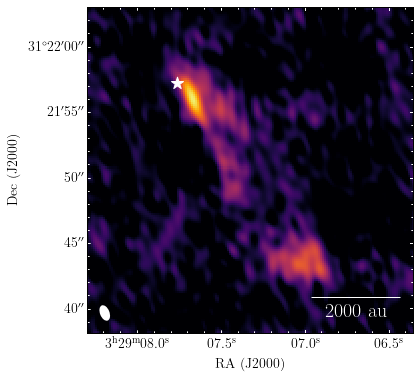

In [3]:
saveaction = 1
folder = 'H2CO/CDconfig/'
filename = H2CO_303_202_TdV_s
stretch = 'arcsinh'
header = fits.getheader(filename+'.fits')
freq = header['RESTFREQ'] * u.Hz
phasecent = [header['ra'], header['dec']]
savefile = folder + 'H2CO_moment0_pretty.pdf'
cmap = 'inferno'

vmin = 0
vmax = 5
vmid = 1

gc = aplpy.FITSFigure(filename + '.fits', figsize=(6,6))
gc.show_colorscale(stretch=stretch, cmap=cmap, vmin=vmin, vmax=vmax, vmid=vmid) 
gc.add_beam()
gc.beam.set_frame(False)
gc.beam.set_facecolor('w')
# fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='k', lw=2)
# fig.add_label(0.05,0.92, r'H$_{2}$CO', color='k',
#                relative=True, horizontalalignment='left', size=13)

# fig.colorbar.set_axis_label_text('Integrated Intensity (K km s$^{-1}$)')
gc.show_markers(ra_Per50.value, dec_Per50.value, marker='*', s=160, layer='star',
                       edgecolor='w', facecolor='w', zorder=31)
distance = 293.
ang_size = (2000 / distance) * u.arcsec
gc.add_scalebar(ang_size, label='2000 au', color='w', corner='bottom right')
gc.scalebar.set_font(family='monospace', size=20)
if saveaction:
  plt.savefig(savefile, bbox_inches='tight', dpi=300)

### Streamline model plots

In [3]:
# Load the streamline results
modelname = 'H2CO_0.18Msun_env_2'
pickle_in = open('analysis/streamer_model_'+modelname+'_vr.pickle', "rb")
streamdict = pickle.load(pickle_in)
ra = streamdict['ra']
dec = streamdict['dec']
dsky = streamdict['d_sky_au']
vel = streamdict['vlsr']
pickle_in = open('analysis/streamer_model_'+modelname+'_params.pickle', "rb")
paramsdict = pickle.load(pickle_in)
omega0 = paramsdict['omega0']
r0 = paramsdict['r0']
v_lsr = paramsdict['v_lsr']

regionfile = 'data/region_streamer_l.reg'

# Load source params
M_s = 1.71*u.Msun # was 2.9
M_env = 0.18*u.Msun # was 2.2
# M_env = 2.2*u.Msun
M_disk = 0.58*u.Msun
Mstar = (M_s+M_env+M_disk)
r_c = SL.r_cent(Mstar, omega0, r0)
print(paramsdict)


{'theta0': <Quantity 61.5 deg>, 'r0': <Quantity 3330. AU>, 'phi0': <Quantity 28. deg>, 'v_r0': <Quantity 1.25 km / s>, 'omega0': <Quantity 4.53e-13 1 / s>, 'v_lsr': <Quantity 7.48 km / s>}


In [4]:
modelname = 'H2CO_0.18Msun_env_2'
pickle_in = open('analysis/streamer_model_'+modelname+'_vr.pickle', "rb")
streamdict = pickle.load(pickle_in)
dsky = streamdict['d_sky_au']
vel1 = streamdict['vlsr']

modelname = 'H2CO_0.39Msun_env'
pickle_in = open('analysis/streamer_model_'+modelname+'_vr.pickle', "rb")
streamdict = pickle.load(pickle_in)
vel2 = streamdict['vlsr']

diff = vel1-vel2[:321]
print(np.amax(diff))

0.07614067372285493 km / s


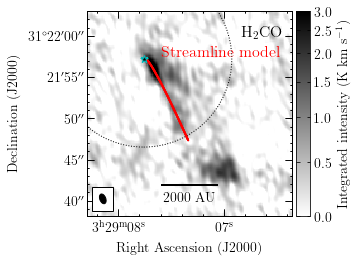

In [5]:
saveplot = 0

# Plot the image plane
filename = H2CO_303_202_
stretch = 'arcsinh'
header = fits.getheader(filename+'.fits')
freq = header['RESTFREQ'] * u.Hz
phasecent = [header['ra'], header['dec']]
vmin = 0
vmax = 3
vmid = 1
cmap='gray_r'
fig = plot_aplpy_standard(filename+'.fits', stretch, vmin, vmax, cmap, label_col='k', star_col='c', vmid=vmid)
fig.show_circles(ra_Per50, dec_Per50, pb_noema(freq).to(u.deg)*0.5,
                  ls=':', color='black')
fig.colorbar.set_axis_label_text(r'Integrated intensity (K km s$^{-1}$)')
fig.show_markers(ra, dec, marker='o', color='red', s=1)
fig.add_label(0.85, 0.9, r'H$_2$CO', relative=True, size=16, weight='bold')
fig.add_label(0.65, 0.8, r'Streamline model', relative=True, size=16, color='r', weight='bold')
if saveplot:
  fig.savefig('analysis/streamline_image_peremb50_'+modelname+'.pdf', dpi=300)

#### Comparison between the two envelope masses with the same parameters

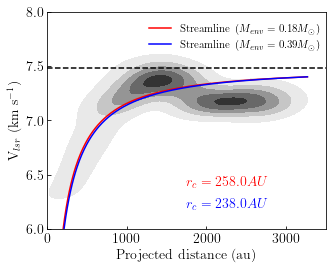

In [64]:
saveplot = 1
regionfile = 'data/region_streamer_l_kink.reg'
r_proj, v_los = per_emb_50_get_vc_r(H2CO_303_202_fit_Vc+'.fits', regionfile)

# create the grid for the kernel distribution
xmin = 0
xmax = 3500
ymin = 6.
ymax = 8.
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
gd_vlos = np.isfinite(r_proj*v_los)  # filter nan
values = np.vstack([r_proj[gd_vlos].value, v_los[gd_vlos].value])

kernel = stats.gaussian_kde(values)
zz = np.reshape(kernel(positions).T, xx.shape)
zz /= zz.max()  # normalization of probability

# plot for kde
fig2 = plt.figure(figsize=(5, 4))
ax2 = fig2.add_subplot(111)
ax2.set_xlabel('Projected distance (au)')
ax2.set_ylabel(r"V$_{lsr}$ (km s$^{-1}$)")
ax2.contourf(xx, yy, zz, cmap='Greys', levels=np.arange(0.1, 1.2, 0.2), vmin=0., vmax=1.2)
ax2.set_ylim([6,8])
ax2.set_xlim([0, 3500])

#Plot for image
filename = H2CO_303_202_TdV_s
stretch = 'arcsinh'
header = fits.getheader(filename+'.fits')
freq = header['RESTFREQ'] * u.Hz
phasecent = [header['ra'], header['dec']]
vmin = 0
vmax = 3
vmid = 0.5
cmap='gray_r'

# Load the streamline results
modelname1 = 'H2CO_0.18Msun_env'
modelname2 = 'H2CO_0.39Msun_env'
pickle_in = open('analysis/streamer_model_'+modelname1+'_vr.pickle', "rb")
streamdict = pickle.load(pickle_in)
ra1 = streamdict['ra']
dec1 = streamdict['dec']
dsky1 = streamdict['d_sky_au']
vel1 = streamdict['vlsr']
pickle_in = open('analysis/streamer_model_'+modelname1+'_params.pickle', "rb")
paramsdict = pickle.load(pickle_in)
omega01 = paramsdict['omega0']
r01 = paramsdict['r0']
pickle_in = open('analysis/streamer_model_'+modelname2+'_vr.pickle', "rb")
streamdict = pickle.load(pickle_in)
ra2 = streamdict['ra']
dec2 = streamdict['dec']
dsky2 = streamdict['d_sky_au']
vel2 = streamdict['vlsr']
pickle_in = open('analysis/streamer_model_'+modelname2+'_params.pickle', "rb")
paramsdict = pickle.load(pickle_in)
omega02 = paramsdict['omega0']
r02 = paramsdict['r0']

v_lsr = paramsdict['v_lsr']

# Load source params
M_s = 1.71*u.Msun # was 2.9
M_env1 = 0.18*u.Msun
M_env2 = 0.39*u.Msun
M_disk = 0.58*u.Msun
Mstar1 = (M_s+M_env1+M_disk)
Mstar2 = (M_s+M_env2+M_disk)
r_c1 = SL.r_cent(Mstar1, omega01, r01)
r_c2 = SL.r_cent(Mstar2, omega02, r02)

# Add the models and labels in the kde
# label=r'Per-emb-50 $v_{lsr}$', 
ax2.axhline(v_lsr.value, color='k', ls='--')
ax2.plot(dsky1, vel1, color='red', label=r'Streamline ($M_{env}=0.18M_{\odot}$)')
ax2.annotate(r'$r_c = {}$'.format(np.round(r_c1,0)), (0.5, 0.2), xycoords='axes fraction', size=14, color='r')
ax2.plot(dsky2, vel2, color='blue', label=r'Streamline ($M_{env}=0.39M_{\odot}$)')
ax2.annotate(r'$r_c = {}$'.format(np.round(r_c2,0)), (0.5, 0.1), xycoords='axes fraction', size=14, color='b')
ax2.legend(loc=(0.35, 0.80), frameon=False, fontsize=11)
# ax2.annotate(r'Per-emb-50 $v_{lsr}$', (0.02, 0.76), xycoords='axes fraction', size=10, color='k')

if saveplot:
  fig2.savefig('figures/streamline_comparison_Menv_vlsr_r_kde_peremb50.pdf', dpi=300, bbox_inches='tight')



#### Velocity gradient with fit region and streamline model

/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdYlBu_r"))
  cm.set_bad(color)
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


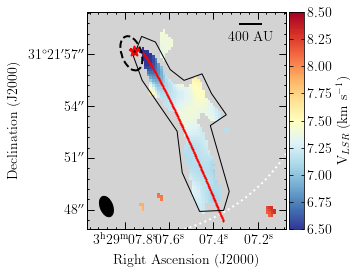

In [44]:
saveaction = 1

# model
modelname = 'H2CO_0.18Msun_env'
pickle_in = open('analysis/streamer_model_'+modelname+'_vr.pickle', "rb")
streamdict = pickle.load(pickle_in)
ra1 = streamdict['ra']
dec1 = streamdict['dec']

folder = 'figures/'
filename = H2CO_303_202_fitparams
savefile = folder + 'H2CO_fitresults_v_lsr_cont_withstream.pdf'
stretch = 'linear'
vmin = 6.5
vmax = 8.5
cmap = 'RdYlBu_r'
regionfile = 'data/region_streamer_l_kink.reg'

paramcube = fits.getdata(filename+'.fits')
moment = paramcube[1]
head = fits.getheader(filename+'.fits')
phasecent = np.array([head['ra'], head['dec']]) *u.deg
freq = head['restfreq'] * u.Hz
header = WCS(head).celestial.to_header()
header['bmaj'] = head['bmaj']
header['bmin'] = head['bmin']
header['bpa'] = head['bpa']
title = r'\textbf{H\boldmath$_{2}$CO}'

ang_size = (400 / 293) * u.arcsec
filename_contour = 'H2CO/CDconfigsmall/Per-emb-50_CD_l021l060_uvsub_H2CO_multi_small_fitcube_stream_mom0'
levels = np.array([3,5]) * 0.25 # K km/s

filename_continuum = continuum_selfcal
cont_data = fits.getdata(filename_continuum+'.fits')[0]
cont_header = WCS(fits.getheader(filename_continuum+'.fits')).celestial.to_header()

fig = plot_aplpy_standard(fits.PrimaryHDU(data=moment, header=header), stretch, vmin, vmax, cmap, label_col='k', star_col='r')
fig.set_nan_color('lightgrey')
fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='w', lw=2)
fig.show_contour(fits.PrimaryHDU(data=cont_data,header=cont_header), levels=[0.007], colors='k', linestyles='dashed', linewidths=2)
fig.colorbar.set_axis_label_text(r'V$_{LSR}$ (km s$^{-1}$)')
# fig.show_contour(filename_contour+'.fits', levels=levels, colors='k', linewidths=0.5)
fig.scalebar.set_corner('top right')
fig.scalebar.set_length(ang_size)
fig.scalebar.set_label('400 AU')
# fig.recenter(52.2814707, 31.3648160,(6*u.arcsec).to(u.deg).value)
fig.recenter(52.2813459, 31.3647663, width=0.0032, height=0.0035)
fig._layers['star']._sizes = np.array([100])
fig._layers['star']._linewidths = np.array([2.])
fig.beam.set_frame(False)
# fig.add_label(0.95,0.9, title, color='k', relative=True, horizontalalignment='right', size=18)
fig.tick_labels.set_xformat('hh:mm:ss.s')
fig.show_regions(regionfile)
fig.show_markers(ra1, dec1, marker='o', c='red', s=0.5)

if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)

## C18O plots

### Moment 0 map

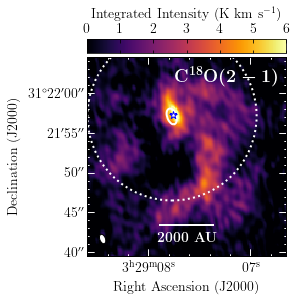

In [26]:
saveaction = 1 


folder = 'figures/'
filename = C18O_2_1_TdV 
cleanalg = 'Multi'
stretch = 'linear'

savefile = folder + 'C18O_'+cleanalg+'_fitcube_total_mom0_labeled_continuum_' + stretch + '.pdf'
vmin = 0
vmax = 6
vmid = 0.5
cmap = 'inferno'
title = r'\textbf{C\boldmath$^{18}$O($2-1$)}'

headercube = fits.getheader(filename+'.fits')
freq = headercube['RESTFREQ'] * u.Hz
phasecent = [headercube['ra'], headercube['dec']]

filename_continuum = 'continuum/Per-emb-50_CD_li_cont_rob1-selfcal'
cont_data = fits.getdata(filename_continuum+'.fits')[0]
cont_header = WCS(fits.getheader(filename_continuum+'.fits')).celestial.to_header()
levels=[0.007]

fig = plot_aplpy_standard(filename+'.fits', stretch, vmin, vmax, cmap, label_col='w', star_col='b', vmid=vmid)
fig.colorbar.set_location('top')
fig.colorbar.set_axis_label_text(r'Integrated Intensity (K km s$^{-1}$)')
fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='w', lw=2)
fig.add_label(0.97,0.9, title, color='w',
               relative=True, horizontalalignment='right', size=18)
# fig.add_label(0.95,0.80, cleanalg, color='k',
#                relative=True, horizontalalignment='right', size=18)
fig.scalebar.set_label(r'\textbf{2000 AU}')
fig.show_contour(fits.PrimaryHDU(cont_data, cont_header), levels=levels, colors='w', linewidths=2)
fig.beam.set_frame(False)
fig.beam.set_facecolor('w')
fig.recenter(52.2817730,31.3644484, 0.0034800)

if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)

#### C18O Position-velocity diagram

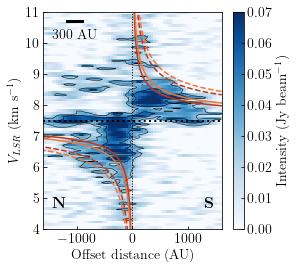

In [5]:
saveaction = 1

pvfile = C18O_2_1_PV
savefile = 'figures/PVdiagram_C18O_pvline_center_Per50_1arcsec_170PA_12arcsec.pdf'
v_lsr = 7.48*u.km/u.s  # +- 0.14 km/s according to out C18O data
arcsectoau = 293  # * u.au / u.arcsec
pvdata = fits.getdata(pvfile+'.fits')
pvheader = fits.getheader(pvfile+'.fits')
rms = 0.01
# contourlevels = np.array([3,5,15,25]) * rms
contourlevels = np.array([3,5]) * rms
vmin = 0
vmax = 0.07

delta0 = pvheader['CRVAL1']
delta_delta = pvheader['CDELT1']
delta_pix0 = pvheader['CRPIX1']
delta_npix = pvheader['NAXIS1']
vel0 = pvheader['CRVAL2']
delta_vel = pvheader['CDELT2']
vel_pix0 = pvheader['CRPIX2']
vel_npix = pvheader['NAXIS2']

delta_array = np.array([delta0 + delta_delta*(i-delta_pix0) for i in range(delta_npix)]) * u.deg
vel_array = np.array([vel0 + delta_vel * (i - vel_pix0) for i in range(vel_npix)]) * u.m/u.s

# transformation to general coordinates
vel_array = vel_array.to(u.km/u.s)
mid_delta = delta_array[int(len(delta_array)/2+2-1)]
offset_array = (delta_array - mid_delta).to(u.arcsec)
distance_array = offset_array.value * arcsectoau * u.au

offset, vel = np.meshgrid(distance_array, vel_array)


fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
norm = simple_norm(pvdata, 'linear', min_cut=vmin,max_cut=vmax)
pcolor = ax.pcolor(offset.value, vel.value, pvdata, shading='auto', norm=norm, cmap='Blues')
contours = ax.contour(offset.value, vel.value, pvdata, contourlevels, colors='k', linewidths=0.5)
fig.colorbar(pcolor, ax=ax, label=r'Intensity (Jy beam$^{-1}$)')
# Now we plot a kepler rotation over it
mstar = [0.5, 0.7, 1.5, 1.9] * u.Msun
inclination = 67 # 0 is face on
# colors = ['red', 'orange', 'red', 'orange']
colors = ['#cc3311', '#ee7733', '#cc3311', '#ee7733']
linestyles = ['-', '-', '--', '--']
radius = np.linspace(1, 1600, 1000) * u.au
radius_neg = np.linspace(-1, -1600, 1000) * u.au
for mass, color, ls in zip(mstar, colors,  linestyles):
    # velocity = v_kepler(mass, radius).to(u.km/u.s) + v_lsr
    velocity = v_kepler(mass, radius).to(u.km/u.s) * np.sin(inclination*np.pi/180)
    velocity_pos = velocity + v_lsr
    velocity_neg = -1*velocity + v_lsr
    ax.plot(radius, velocity_pos, ls=ls, color=color,
            label=r'$M_{\star}='+str(mass.value)+r'M_{\odot}$')
    ax.plot(radius_neg, velocity_neg, ls=ls, color=color)
    
ax.axhline(v_lsr.value, color='k', linestyle=':', linewidth=2)
ax.axvline(0, color='k', linestyle=':', linewidth=1)
ax.set_ylim([4, 11])
ax.set_ylabel(r'$V_{LSR}$ (km s$^{-1}$)')
ax.set_xlim([-1600, 1600])
ax.set_xlabel('Offset distance (AU)')
# ax.legend(fontsize=8, loc=4)
# ax.annotate(r'rms = 0.01 Jy beam$^{-1}$', (0.05, 0.05), xycoords='axes fraction', color='k', size=8)
# ax.annotate(r'i = 67$^{\circ}$', (0.05, 0.01), xycoords='axes fraction', color='k', size=10)
ax.annotate(r'\textbf{N}', (0.05, 0.1), xycoords='axes fraction', color='k', size=16)
ax.annotate(r'\textbf{S}', (0.90, 0.1), xycoords='axes fraction', color='k', size=16)


bar = AnchoredSizeBar(ax.transData, 300, '300 AU', 2, pad=0.1, borderpad=0.5, sep=5,  frameon=False, color='k', size_vertical=0.08)
ax.add_artist(bar)

if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)

### C18O with H2CO overlaid

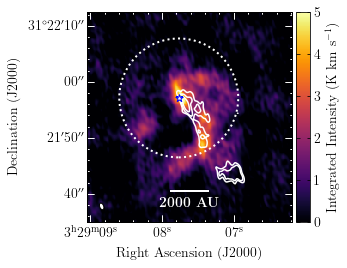

In [16]:
saveaction = 1

folder = 'C18O/CDconfig/'
filename = C18O_2_1_TdV 
filename_contour = H2CO_303_202_TdV_s
cleanalg = 'Multi'
stretch = 'linear'

savefile = folder + 'C18O_'+cleanalg+'_fitcube_total_mom0' + '_'+stretch + '_H2COcontour_nolabels.pdf'
vmin = 0
vmax = 5
vmid = 0.5
cmap = 'inferno'
title = r'\textbf{C\boldmath$^{18}$O($2-1$)}'

headercube = fits.getheader(filename+'.fits')
freq = headercube['RESTFREQ'] * u.Hz
phasecent = [headercube['ra'], headercube['dec']]

fig = plot_aplpy_standard(filename+'.fits', stretch, vmin, vmax, cmap, label_col='w', star_col='b', vmid=vmid)
fig.colorbar.set_axis_label_text(r'Integrated Intensity (K km s$^{-1}$)')
fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='w', lw=2)
# fig.add_label(0.95,0.9, title, color='y',
#                relative=True, horizontalalignment='right', size=14)
fig.scalebar.set_label(r'\textbf{2000 AU}')

rms, __ = calculatenoise(fits.getdata(filename_contour+'.fits'))
levels = rms * np.array([3, 5, 10])
fig.show_contour(filename_contour+'.fits', colors='w', levels=levels)
# fig.add_label(0.95,0.8, r'\textbf{H\boldmath$_{2}$CO($3_{0,3}-2_{0,2}$)}', color='w',
#                relative=True, horizontalalignment='right', size=14)
fig.beam.set_frame(False)
fig.beam.set_facecolor('w')
if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)


### Fit results

/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdYlBu_r"))
  cm.set_bad(color)
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap

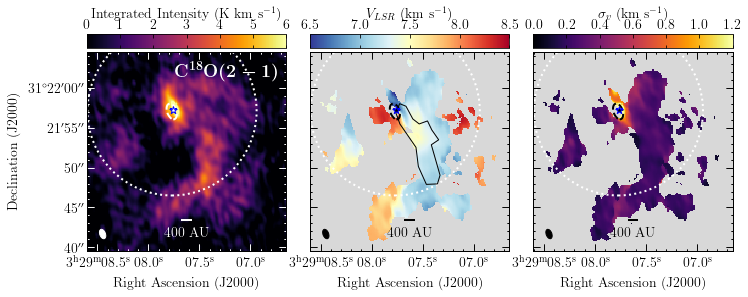

In [17]:
saveaction = 1

filename = C18O_2_1_fitparams
folder = 'figures/'
savefile = folder + 'C18O_fitresults_v_sigmav.pdf'
stretch = 'linear'
cmap = ['RdYlBu_r', 'inferno']
paramcube = fits.getdata(filename+'.fits')
head = fits.getheader(filename+'.fits')
phasecent = np.array([head['ra'], head['dec']]) *u.deg
freq = head['restfreq'] * u.Hz
header = WCS(head).celestial.to_header()
header['bmaj'] = head['bmaj']
header['bmin'] = head['bmin']
header['bpa'] = head['bpa']
regionfile = 'data/region_streamer_l_kink.reg'

filename_continuum = continuum_selfcal
cont_data = fits.getdata(filename_continuum+'.fits')[0]
cont_header = WCS(fits.getheader(filename_continuum+'.fits')).celestial.to_header()

vmin = [6.5, 0.]
vmax = [8.5, 1.2]
ang_size = (400 / 293) * u.arcsec
colorbarlabel = ['Peak intensity (K)', r'$V_{LSR}$ (km s$^{-1}$)', r'$\sigma_v$ (km s$^{-1}$)']

fig = plt.figure(figsize=(12,4))
# C18O_2_1_TdV
title = r'\textbf{C\boldmath$^{18}$O($2-1$)}'
gc0 = plot_aplpy_subfig(C18O_2_1_TdV+'.fits', fig, (1,3,1), stretch, 0, 6, 'inferno', label_col='w', star_col='b')
gc0.colorbar.set_location('top')
gc0.colorbar.set_axis_label_text(r'Integrated Intensity (K km s$^{-1}$)')
gc0.scalebar.set_length(ang_size)
gc0.scalebar.set_label('400 AU')
gc0.colorbar.set_axis_label_pad(0.43)
gc0.beam.set_frame(False)
gc0.beam.set_color('w')
gc0.recenter(52.2817730,31.3644484, 0.0034800)
gc0.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='w', lw=2)
gc0.show_contour(fits.PrimaryHDU(data=cont_data,header=cont_header), levels=[0.007], colors='w', linestyles='dashed', linewidths=2)
gc0.add_label(0.97,0.9, title, color='w',
               relative=True, horizontalalignment='right', size=18)
gc0.tick_labels.set_xformat('hh:mm:ss.s')
for i in range(1,3):
  component1 = fits.PrimaryHDU(data=paramcube[i],header=header)
  gc1 = plot_aplpy_subfig(component1, fig, (1,3,i+1), stretch, vmin[i-1], vmax[i-1], cmap[i-1], label_col='k', star_col='b')
  gc1.colorbar.set_location('top')
  gc1.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='w', lw=2)
  gc1.set_nan_color(np.array([1,1,1])*0.85)
  gc1.show_contour(fits.PrimaryHDU(data=cont_data,header=cont_header), levels=[0.007], colors='k', linestyles='dashed', linewidths=2)
  gc1.scalebar.set_length(ang_size)
  gc1.scalebar.set_label('400 AU')
  gc1.colorbar.set_axis_label_text(colorbarlabel[i])
  gc1.colorbar.set_axis_label_pad(0.4)
  gc1.beam.set_frame(False)
  gc1.recenter(52.2817730,31.3644484, 0.0034800)
  gc1.tick_labels.set_xformat('hh:mm:ss.s')
  if i:
    gc1.tick_labels.hide_y()
    gc1.axis_labels.hide_y()
  if i==1:
    gc1.colorbar.set_ticks([6.5, 7,7.5,8,8.5])
    gc1.show_regions(regionfile)
fig.subplots_adjust(wspace=0.0)
    
if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)

### Streamline model results

/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdYlBu_r"))
  cm.set_bad(color)
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


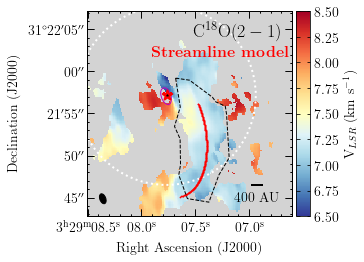

In [8]:
saveaction = 1

modelname = 'C18O_0.18Msun_env'
pickle_in = open('analysis/streamer_model_'+modelname+'_vr.pickle', "rb")
streamdict = pickle.load(pickle_in)
ra1 = streamdict['ra']
dec1 = streamdict['dec']
dsky = streamdict['d_sky_au']
vel = streamdict['vlsr']
regionfile = 'data/region_streamer_C18O_final.reg'

# Load source params
M_s = 1.71*u.Msun # was 2.9
M_env = 0.18*u.Msun # was 2.2
M_disk = 0.58*u.Msun
Mstar = (M_s+M_env+M_disk)

filename = C18O_2_1_fit_Vc
stretch = 'linear'
vmin = 6.5
vmax = 8.5
cmap = 'RdYlBu_r'
header = fits.getheader(filename+'.fits')
freq = header['RESTFREQ'] * u.Hz
phasecent = [header['ra'], header['dec']]
title = r'C$^{18}$O($2-1$)'

ang_size = (400 / 293) * u.arcsec
centra = 52.2814760
centdec = 31.3652689
radiusplot = 0.0033887 * u.deg

filename_continuum = 'continuum/Per-emb-50_CD_li_cont_rob1-selfcal'
cont_data = fits.getdata(filename_continuum+'.fits')[0]
cont_header = WCS(fits.getheader(filename_continuum+'.fits')).celestial.to_header()

fig = plot_aplpy_standard(filename+'.fits', stretch, vmin, vmax, cmap, label_col='k', star_col='r')
fig.set_nan_color('lightgrey')
fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='w', lw=2)
fig.colorbar.set_axis_label_text(r'V$_{LSR}$ (km s$^{-1}$)')
fig.scalebar.set_corner('bottom right')
fig.scalebar.set_length(ang_size)
# fig.scalebar.set_corner('bottom center')
fig.scalebar.set_label('400 AU')
fig.show_contour(fits.PrimaryHDU(data=cont_data,header=cont_header), levels=[0.007], colors='m', linewidths=1)
# fig.recenter(ra_Per50.value, dec_Per50.value, (6*u.arcsec).to(u.deg).value)
fig.recenter(centra, centdec,radiusplot.value)
fig._layers['star']._sizes = np.array([100])
fig._layers['star']._linewidths = np.array([2.])
fig.beam.set_frame(False)
fig.add_label(0.95,0.9, title, color='k',
               relative=True, horizontalalignment='right', size=18)
fig.add_label(0.65, 0.8, r'\textbf{Streamline model}', relative=True, size=16, color='r')
fig.tick_labels.set_xformat('hh:mm:ss.s')
fig.show_regions(regionfile)
fig.show_markers(ra1, dec1, marker='o', c='red', s=0.5)

if saveaction:
    savefile = filename + '_cont_withstream.pdf'
    plt.savefig(savefile, bbox_inches='tight', dpi=300)

Comparison between  the streamline models with the different envelope masses

FileNotFoundError: [Errno 2] No such file or directory: 'analysis/streamer_model_C18O_0.18Msun_env_vr.pickle'

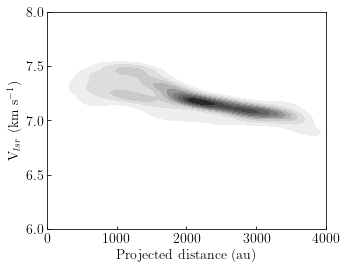

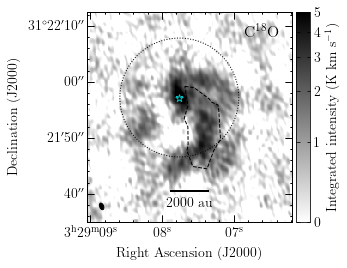

In [12]:
saveplot = 1
regionfile = 'data/region_streamer_C18O_final.reg'
r_proj, v_los = per_emb_50_get_vc_r(C18O_2_1_fit_Vc+'.fits', regionfile)

# create the grid for the kernel distribution
xmin = 0
xmax = 4000
ymin = 6.
ymax = 8.
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
#
gd_vlos = np.isfinite(r_proj*v_los)  # filter nan
values = np.vstack([r_proj[gd_vlos].value, v_los[gd_vlos].value])

kernel = stats.gaussian_kde(values)
zz = np.reshape(kernel(positions).T, xx.shape)
zz /= zz.max()  # normalization of probability

# plot for kde
fig2 = plt.figure(figsize=(5, 4))
ax2 = fig2.add_subplot(111)
ax2.set_xlabel('Projected distance (au)')
ax2.set_ylabel(r"V$_{lsr}$ (km s$^{-1}$)")
ax2.contourf(xx, yy, zz, cmap='Greys', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax2.set_ylim([6,8])
ax2.set_xlim([0, 4000])

#Plot for image
filename = C18O_2_1_TdV
stretch = 'arcsinh'
header = fits.getheader(filename+'.fits')
freq = header['RESTFREQ'] * u.Hz
phasecent = [header['ra'], header['dec']]
vmin = 0
vmax = 5
vmid = 1
cmap='gray_r'

fig = plot_aplpy_standard(filename+'.fits', stretch, vmin, vmax, cmap, label_col='k', star_col='c', vmid=vmid)
fig.show_circles(ra_Per50, dec_Per50, pb_noema(freq).to(u.deg)*0.5,
                  ls=':', color='black')
fig.colorbar.set_axis_label_text(r'Integrated intensity (K km s$^{-1}$)')
fig.add_label(0.85, 0.9, r'C$^{18}$O', relative=True, size=16, weight='bold')
fig.show_regions(regionfile)

# Load the streamline results
modelname1 = 'C18O_0.18Msun_env'
modelname2 = 'C18O_0.39Msun_env'
pickle_in = open('analysis/streamer_model_'+modelname1+'_vr.pickle', "rb")
streamdict = pickle.load(pickle_in)
ra1 = streamdict['ra']
dec1 = streamdict['dec']
dsky1 = streamdict['d_sky_au']
vel1 = streamdict['vlsr']
pickle_in = open('analysis/streamer_model_'+modelname1+'_params.pickle', "rb")
paramsdict = pickle.load(pickle_in)
omega01 = paramsdict['omega0']
r01 = paramsdict['r0']
pickle_in = open('analysis/streamer_model_'+modelname2+'_vr.pickle', "rb")
streamdict = pickle.load(pickle_in)
ra2 = streamdict['ra']
dec2 = streamdict['dec']
dsky2 = streamdict['d_sky_au']
vel2 = streamdict['vlsr']
pickle_in = open('analysis/streamer_model_'+modelname2+'_params.pickle', "rb")
paramsdict = pickle.load(pickle_in)
omega02 = paramsdict['omega0']
r02 = paramsdict['r0']

v_lsr = paramsdict['v_lsr']

# Load source params
M_s = 1.71*u.Msun # was 2.9
M_env1 = 0.18*u.Msun
M_env2 = 0.39*u.Msun
M_disk = 0.58*u.Msun
Mstar1 = (M_s+M_env1+M_disk)
Mstar2 = (M_s+M_env2+M_disk)
r_c1 = SL.r_cent(Mstar1, omega01, r01)
r_c2 = SL.r_cent(Mstar2, omega02, r02)

# Add the models and labels in the kde

ax2.axhline(v_lsr.value, color='k', label=r'Per-emb-50 $v_{lsr}$', ls='--')
ax2.plot(dsky1, vel1, color='red', label=r'Streamline ($M_{env}=0.18M_{\odot}$)')
ax2.annotate(r'$r_c = {}$'.format(np.round(r_c1,0)), (0.5, 0.2), xycoords='axes fraction', size=14, color='r')
ax2.plot(dsky2, vel2, color='blue', label=r'Streamline ($M_{env}=0.39M_{\odot}$)')
ax2.annotate(r'$r_c = {}$'.format(np.round(r_c2,0)), (0.5, 0.1), xycoords='axes fraction', size=14, color='b')
ax2.legend(loc=(0.35, 0.75), frameon=False, fontsize=11)

#add the models and labels in the image
fig.show_markers(ra1, dec1, marker='o', c='red', s=0.5)
# fig.add_label(0.3, 0.3, r'$M_{env}=0.18M_{\odot}$', relative=True, size=16, color='r', weight='bold')
fig.show_markers(ra2, dec2, marker='o', c='b', s=0.5)
# fig.add_label(0.3, 0.2, r'$M_{env}=0.39M_{\odot}$', relative=True, size=16, color='b', weight='bold')

if saveplot:
  fig2.savefig('analysis/streamline_C18O_comparison_Menv_vlsr_r_kde_peremb50.pdf', dpi=300, bbox_inches='tight')
  fig.savefig('analysis/streamline_C18O_image_comparison_Menv_peremb50.pdf', dpi=300)

### N(C18O) and mass accretion results

/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cm.set_bad(color)


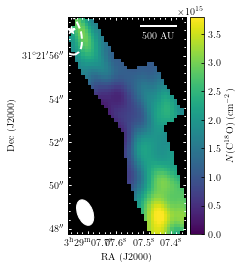

In [4]:
saveaction = 0
folder = 'analysis/column_dens_maps/'
filename = folder+'N_C18O_constantTex_15pm5K_mom0_pbcor_kink'
# folder = 'C18O/CDconfig/JEP/'
# filename = folder+'JEP_mask_multi_Per-emb-50_CD_l025l064_uvsub_C18O_pbcor_reprojectH2COs_mom0_l_kink'
stretch = 'linear'
cmap = 'viridis'
vmin = 0
vmax = 3.8e15
label_col='w'
star_col='w'
savefile = filename + '_with_cont.pdf'

distance = 293.
ang_size = (500 / distance) * u.arcsec
filename_continuum = 'continuum/Per-emb-50_CD_li_cont_rob1-selfcal'
cont_data = fits.getdata(filename_continuum+'.fits')[0]
cont_header = WCS(fits.getheader(filename_continuum+'.fits')).celestial.to_header()

# fig = plot_aplpy_standard(filename + '.fits', stretch, vmin, vmax, cmap, label_col='k', star_col='k')
fig = aplpy.FITSFigure(filename+'.fits', figsize=(4,4))
fig.show_colorscale(vmin=vmin,vmax=vmax)
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'$N(\mathrm{C}^{18}\mathrm{O})$ (cm$^{-2}$)')
# fig.colorbar.set_axis_label_text(r'Integrated intensity (K km s$^{-1}$)')
fig.show_contour(fits.PrimaryHDU(data=cont_data,header=cont_header), levels=[0.007], colors='w', linewidths=2,linestyles='dashed')
fig.add_beam()
fig.set_system_latex(True)
fig.ticks.set_color(label_col)
fig.beam.set_color('w')
# fig.beam.set_frame(True)
fig.add_scalebar(ang_size, label='2000 AU', color=label_col, corner='top right')
fig.set_nan_color('k')
fig.scalebar.set_label('500 AU')
fig.scalebar.set_font(family='monospace', weight=1000)
fig.show_markers(ra_Per50.value, dec_Per50.value, marker='*', s=60, layer='star',
                       edgecolor=star_col, facecolor=label_col, zorder=31)
fig.scalebar.set_linewidth(2)
if saveaction:
  plt.savefig(savefile, bbox_inches='tight', dpi=300)


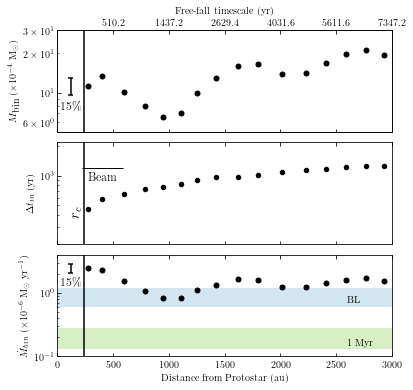

In [7]:
# If the free fall time is not trivial (like in this case), we can plot a third row
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=12)
saveaction = 1
uncert = 0.15
savefolder = 'figures/'
savefile = savefolder + 'plot_mass_accretion_radius_rmsunc_rolledbin_wcaliberror.pdf'
# define tick function
# the conversion function is t_freefall_acc_v0 from NOEMAsetup.py

modelname = 'H2CO_0.39Msun_env'
fileinpickle = 'analysis/streamer_model_'+modelname+'_params'

pickle_in = open(fileinpickle+'.pickle', "rb")
streamdict = pickle.load(pickle_in)
r0 = streamdict['r0']
v_r0 = streamdict['v_r0']
M_s = 1.71 * u.Msun
M_env = 0.39 * u.Msun
M_disk = 0.58 * u.Msun
Mstar = (M_s + M_env + M_disk)

def tick_function(X):
  V = np.ones(np.shape(X)) * u.yr
  for i in range(len(X)):
    V[i] = t_freefall_acc_v0(0*u.au, X[i]* u.au, r0, v0=v_r0, mass=Mstar)
  V_real = V.value
  return ["%.1f" % z for z in V_real]

folder = 'analysis/'
# Just changed the uncertainties for Tex
tablefilemacc = 'M_Mdot_Tex_15pm5_mom0_pbcor_rolledbin_unc_tmodel_Menv_0.39Msun.csv'

mass_streamer_table = pd.read_csv(folder+tablefilemacc, header=0)
binradiikink = mass_streamer_table['3D distance kink (au)']
masseskink = mass_streamer_table['Mass w kink (Msun)']
umasseskink = mass_streamer_table['u Mass w kink (Msun)']
m_acclistkink = mass_streamer_table['Mdot_in w kink (Msun yr-1)']
um_acclistkink = mass_streamer_table['u Mdot_in w kink (Msun yr-1)']
times_streamlinekink = mass_streamer_table['t_ff streamline kink (yr, M_env = 0.39 Msun)']
utimes_streamlinekink = mass_streamer_table['u t_ff streamline kink (yr, M_env = 0.39 Msun)']
deltatlist = mass_streamer_table['deltat_ff streamline (yr, M_env = 0.39 Msun)']

fig = plt.figure(figsize=(6,6))
ax3 = fig.add_subplot(313)
ax3.errorbar(binradiikink, m_acclistkink*1e6, yerr=um_acclistkink*1e6, marker='o', linestyle='none', mfc='k', mec='k', ecolor='k', ms=5)
ax3.set_yscale('log')
ax3.set_xlabel('Distance from Protostar (au)')
ax3.set_ylabel(r'$\dot{M}_{bin}$ ($\times 10^{-6}$ M$_{\odot}$ yr$^{-1}$)', fontsize=10)
ax3.set_ylim([0.1,4])
ax3.axvline(237.5, color='k') # rc
ax3.set_xlim([0,3000])
ax3.axhspan(0.6, 1.2, facecolor='#a6cee3', label=r'$\dot{M}_{acc}$ BL', alpha=0.5)
ax3.axhspan(0.13, 0.28, facecolor='#b2df8a', label=r'$\dot{M}_{acc}$ 1 Myr', alpha=0.5)
ax3.vlines(120, (m_acclistkink*1e6)[0]*(1-uncert), (m_acclistkink*1e6)[0]*(1+uncert), colors='k', linewidths=1.5)
ax3.hlines(((m_acclistkink*1e6)[0]*(1-uncert), (m_acclistkink*1e6)[0]*(1+uncert)), 100, 140, colors='k', linewidths=1.5)
ax3.annotate(str(int(uncert*100))+'\%', (30, 1.3), xycoords='data', size=12)
ax3.annotate('BL', (2600, 0.7), xycoords='data')
ax3.annotate('1 Myr', (2600, 0.15), xycoords='data')
ax3.tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=True)


new_tick_locations = np.array([500, 1000, 1500, 2000, 2500, 3000]) 
ax = fig.add_subplot(311, sharex=ax3)
ax.errorbar(binradiikink, masseskink*1e4, yerr=umasseskink*1e4, marker='o', linestyle='none', mfc='k', mec='k', ecolor='k', label='kink', ms=5)
ax.set_ylabel(r'$M_{\textrm{bin}}$ ($\times 10^{-4}$ M$_{\odot}$)', fontsize=10)
ax.axvline(237.5, color='k')
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.set_ylim([5,30])
ax.set_yscale('log')
ax.vlines(120, (masseskink*1e4)[0]*(1-uncert), (masseskink*1e4)[0]*(1+uncert), colors='k', linewidths=1.5)
ax.hlines(((masseskink*1e4)[0]*(1-uncert), (masseskink*1e4)[0]*(1+uncert)), 100, 140, colors='k', linewidths=1.5)
ax.annotate(str(int(uncert*100))+'\%', (30, 7.5), xycoords='data', size=12)
ax1_double = ax.twiny()
ax1_double.set_xticks(new_tick_locations)
ax1_double.set_xlabel('Free-fall timescale (yr)')
ax1_double.set_xticklabels(tick_function(new_tick_locations))

ax2 = fig.add_subplot(312, sharex=ax3)
ax2.scatter(binradiikink, deltatlist, s=20, facecolors='k', edgecolors='k')
ax2.set_ylabel(r'$\Delta t_{in}$ (yr)', fontsize=10)
ax2.set_yscale('log')
ax2.set_ylim([200,2200])
ax2.axvline(237.5, color='k')
ax2.tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=False)
ax2.text(100,400, r'$r_c$', size=15, rotation=90, color='k')

# scalebar
scalebar = AnchoredSizeBar(ax.transData,
                          360, 'Beam', 'upper left', 
                           pad=2,
                           color='k',
                           frameon=False,
                           size_vertical=0,
                           sep=3,
                           fontproperties=fontprops)
ax2.add_artist(scalebar)
fig.subplots_adjust(hspace=0.1)

if saveaction:
  fig.savefig(savefile, dpi=300, bbox_inches='tight')

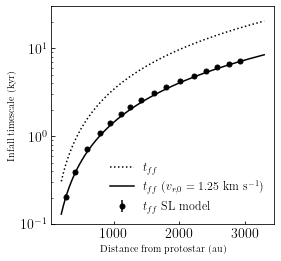

In [3]:
# needs the previous box to be run
saveaction = 0
plotname = 'analysis/t_ff_comparison_classic_SLmodel.pdf'
modelname = 'H2CO_0.39Msun_env'
fileinpickle = 'analysis/streamer_model_'+modelname+'_params'

pickle_in = open(fileinpickle+'.pickle', "rb")
streamdict = pickle.load(pickle_in)
r0 = streamdict['r0']
v_r0 = streamdict['v_r0']
M_s = 1.71 * u.Msun
M_env = 0.39 * u.Msun
M_disk = 0.58 * u.Msun
Mstar = (M_s + M_env + M_disk)

r_sample = np.arange(200, 3310, 10) *u.au
time_theory_acc = np.zeros(np.shape(r_sample)) * u.yr
for i in range(len(r_sample)):
  time_theory_acc[i] = t_freefall_acc_v0(0*u.au, r_sample[i], r0, v0=v_r0, mass=Mstar)
time_theory = t_freefall(r_sample, 2.68*u.Msun)

fig = plt.figure(figsize=(4,4))
ax2 = fig.add_subplot(111)
ax2.errorbar(binradiikink, times_streamlinekink/1e3, yerr=utimes_streamlinekink/1e3, marker='o', linestyle='none', mfc='k', mec='k', ecolor='k', ms=5, label=r'$t_{ff}$ SL model')
ax2.plot(r_sample.value, time_theory.value/1e3, 'k:', label=r'$t_{ff}$')
ax2.plot(r_sample.value, time_theory_acc.value/1e3, 'k-', label=r'$t_{ff}$ ($v_{r,0}=1.25$ km s$^{-1}$)')
ax2.set_ylabel(r'Infall timescale (kyr)', fontsize=10)
ax2.set_xlabel(r'Distance from protostar (au)', fontsize=10)
ax2.set_yscale('log')
ax2.set_ylim([0.1,30])
# ax2.set_xlim([0, 3100])
ax2.legend(frameon=False, fontsize=12)
if saveaction:
  fig.savefig(plotname, dpi=300, bbox_inches='tight')


## SO2 plots

#### Moment 0

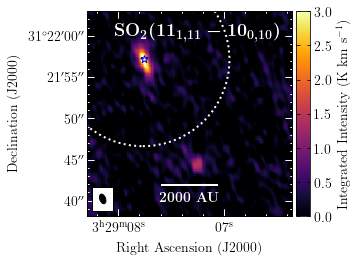

In [9]:
saveaction = 1

folder = 'SO2_11_1_11_10_0_10/CDconfig/'
filename = folder+'Per-emb-50_CD_l031l070_uvsub_SO2_multi_fitcube_stream_mom0'
cleanalg = 'Multi'
stretch = 'linear'

savefile = folder + 'C18O_'+cleanalg+'_fitcube_total_mom0' + '_'+stretch + '.pdf'
vmin = 0
vmax = 3
vmid = 0.5
cmap = 'inferno'
title = r'\textbf{SO\boldmath$_{2}$($11_{1,11}-10_{0,10}$)}'

headercube = fits.getheader(filename+'.fits')
freq = headercube['RESTFREQ'] * u.Hz
phasecent = [headercube['ra'], headercube['dec']]

fig = plot_aplpy_standard(filename+'.fits', stretch, vmin, vmax, cmap, label_col='w', star_col='b', vmid=vmid)
fig.colorbar.set_axis_label_text(r'Integrated Intensity (K km s$^{-1}$)')
fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='w', lw=2)
fig.add_label(0.95,0.9, title, color='w',
               relative=True, horizontalalignment='right', size=18)
# fig.add_label(0.95,0.80, cleanalg, color='k',
#                relative=True, horizontalalignment='right', size=18)
fig.scalebar.set_label(r'\textbf{2000 AU}')

if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)

#### SO2 Position-velocity diagram

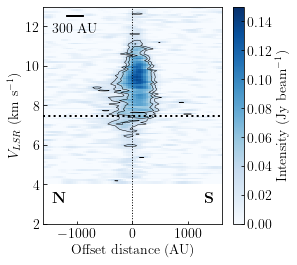

In [4]:
saveaction = 1

pvfile = SO2_11_1_11_10_0_10_PV
savefile = 'figures/PVdiagram_SO2_pvline_center_Per50_1arcsec_170PA_12arcsec.pdf'
v_lsr = 7.48*u.km/u.s  # +- 0.14 km/s according to out C18O data
arcsectoau = 293  # * u.au / u.arcsec
pvdata = fits.getdata(pvfile+'.fits')
pvheader = fits.getheader(pvfile+'.fits')
rms = 0.01
contourlevels = np.array([3,5,15,25,35, 45]) * rms
# contourlevels = np.array([3,5]) * rms
vmin = 0
vmax = 0.15

delta0 = pvheader['CRVAL1']
delta_delta = pvheader['CDELT1']
delta_pix0 = pvheader['CRPIX1']
delta_npix = pvheader['NAXIS1']
vel0 = pvheader['CRVAL2']
delta_vel = pvheader['CDELT2']
vel_pix0 = pvheader['CRPIX2']
vel_npix = pvheader['NAXIS2']

delta_array = np.array([delta0 + delta_delta*(i-delta_pix0) for i in range(delta_npix)]) * u.deg
vel_array = np.array([vel0 + delta_vel * (i - vel_pix0) for i in range(vel_npix)]) * u.m/u.s

# transformation to general coordinates
vel_array = vel_array.to(u.km/u.s)
mid_delta = delta_array[int(len(delta_array)/2+2-1)]
offset_array = (delta_array - mid_delta).to(u.arcsec)
distance_array = offset_array.value * arcsectoau * u.au

offset, vel = np.meshgrid(distance_array, vel_array)

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
norm = simple_norm(pvdata, 'linear', min_cut=vmin,max_cut=vmax)
pcolor = ax.pcolor(offset.value, vel.value, pvdata, shading='auto', norm=norm, cmap='Blues')
contours = ax.contour(offset.value, vel.value, pvdata, contourlevels, colors='k', linewidths=0.5)
fig.colorbar(pcolor, ax=ax, label=r'Intensity (Jy beam$^{-1}$)')
    
ax.axhline(v_lsr.value, color='k', linestyle=':', linewidth=2)
ax.axvline(0, color='k', linestyle=':', linewidth=1)
ax.set_ylim([2, 13])
ax.set_ylabel(r'$V_{LSR}$ (km s$^{-1}$)')
ax.set_xlim([-1600, 1600])
ax.set_xlabel('Offset distance (AU)')
ax.annotate(r'\textbf{N}', (0.05, 0.1), xycoords='axes fraction', color='k', size=16)
ax.annotate(r'\textbf{S}', (0.90, 0.1), xycoords='axes fraction', color='k', size=16)

bar = AnchoredSizeBar(ax.transData, 300, '300 AU', 2, pad=0.1, borderpad=0.5, sep=5,  frameon=False, color='k', size_vertical=0.08)
ax.add_artist(bar)

if saveaction:
  plt.savefig(savefile, bbox_inches='tight', dpi=300)

SO2 mom0 zoom with SO and H2CO contours and sample region

/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


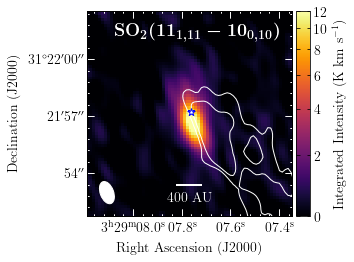

In [3]:
saveaction = 1

folder = 'figures/'
filename = SO2_11_1_11_10_0_10_TdV
stretch = 'arcsinh'
savefile = folder + 'SO2_total_mom0_H2CO_cont.pdf'
vmin = 0
vmax = 12
vmid = 3
cmap = 'inferno'
title = r'\textbf{SO\boldmath$_{2}$($11_{1,11}-10_{0,10}$)}'

filename_H2COcontour = 'H2CO/CDconfigsmall/Per-emb-50_CD_l021l060_uvsub_H2CO_multi_small_fitcube_stream_mom0'
levelsH2CO = [0.75, 1.25]
regionsfile = folder+'samples_subset.reg'

headercube = fits.getheader(filename+'.fits')
freq = headercube['RESTFREQ'] * u.Hz
phasecent = [headercube['ra'], headercube['dec']]
ang_size = (400/293)*u.arcsec

fig = plot_aplpy_standard(filename+'.fits', stretch, vmin, vmax, cmap, label_col='w', star_col='b', vmid=vmid)
fig.colorbar.set_axis_label_text(r'Integrated Intensity (K km s$^{-1}$)')
fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='w', lw=2)
fig.recenter(phasecent[0], phasecent[1], 0.0015)
fig.show_contour(filename_H2COcontour+'.fits', levels=levelsH2CO, colors='w', linewidths=1)
# fig.show_regions(regionsfile)
fig.scalebar.set_length(ang_size)
fig.scalebar.set_label('400 AU')
fig.tick_labels.set_xformat('hh:mm:ss.s')
fig.beam.set_color('w')

fig.add_label(0.95,0.9, title, color='w', relative=True, horizontalalignment='right', size=18)
# fig.scalebar.set_label(r'\textbf{2000 AU}')
 

if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)

SO2 with H2CO contours

/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


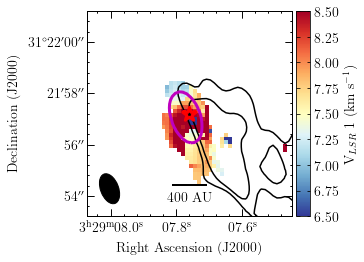

In [16]:
saveaction = 0

filename = 'SO2_11_1_11_10_0_10/CDconfig/gaussian_model_12G/Per-emb-50_CD_l031l070_uvsub_SO2_multi_gaussian_rest_model'
stretch = 'linear'
paramcube = fits.getdata(filename+'.fits')
head = fits.getheader(filename+'.fits')
phasecent = np.array([head['ra'], head['dec']]) *u.deg
freq = head['restfreq'] * u.Hz
header = WCS(head).celestial.to_header()
header['bmaj'] = head['bmaj']
header['bmin'] = head['bmin']
header['bpa'] = head['bpa']
moment = paramcube[1]

vmin = 6.5
vmax = 8.5
cmap = 'RdYlBu_r'


ang_size = (400 / 293) * u.arcsec

filename_contour = 'H2CO/CDconfigsmall/Per-emb-50_CD_l021l060_uvsub_H2CO_multi_small_fitcube_stream_mom0'
levels = np.array([3,5]) * 0.25 # K km/s

filename_continuum = 'continuum/Per-emb-50_CD_li_cont_rob1-selfcal'
cont_data = fits.getdata(filename_continuum+'.fits')[0]
cont_header = WCS(fits.getheader(filename_continuum+'.fits')).celestial.to_header()

fig = plot_aplpy_standard(fits.PrimaryHDU(data=moment, header=header), stretch, vmin, vmax, cmap, label_col='k', star_col='r')
fig.colorbar.set_axis_label_text(r'V$_{LSR}$ 1 (km s$^{-1}$)')
fig.show_contour(filename_contour+'.fits', levels=levels, colors='k')
fig.scalebar.set_length(ang_size)
fig.scalebar.set_label('400 AU')
fig.show_contour(fits.PrimaryHDU(data=cont_data,header=cont_header), levels=[0.007], colors='m', linewidths=3)
fig.recenter(ra_Per50.value, dec_Per50.value, (4*u.arcsec).to(u.deg).value)
fig._layers['star']._sizes = np.array([200])
fig._layers['star']._linewidths = np.array([3.])
fig.tick_labels.set_xformat('hh:mm:ss.s')
fig.beam.set_frame(False)

if saveaction:
    savefile = filename + '_v_lsr1_H2CO_cont.pdf'
    plt.savefig(savefile, bbox_inches='tight', dpi=300)
  

# Continuum Image (preliminary, self-cal)

/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


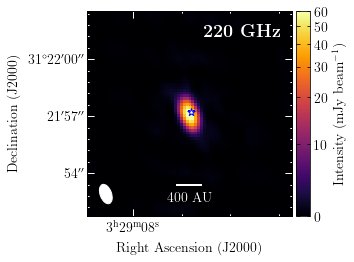

In [11]:
saveaction = 1

folder = 'figures/'
filename = continuum_selfcal
cleanalg = 'Multi'
stretch = 'arcsinh'

savefile = folder + 'continuum_li_selfcal_'+stretch + '.pdf'
vmin = 0
vmax = 60
vmid = 10
cmap = 'inferno'
title = r'\textbf{220 GHz}'
ang_size = (400 / 293) * u.arcsec

headercube = fits.getheader(filename+'.fits')
freq = headercube['RESTFREQ'] * u.Hz
phasecent = [headercube['ra'], headercube['dec']]
wcscel = WCS(headercube).celestial
new_header = wcscel.to_header()
new_header['bmaj'] = headercube['bmaj']
new_header['bmin'] = headercube['bmin']
new_header['bpa'] = headercube['bpa']
new_hdu = fits.PrimaryHDU(data=fits.getdata(filename+'.fits')[0]*1000,header=new_header)
fig = plot_aplpy_standard(new_hdu, stretch, vmin, vmax, cmap, label_col='w', star_col='b', vmid=vmid)
fig.colorbar.set_axis_label_text(r'Intensity (mJy beam$^{-1}$)')
fig.scalebar.set_length(ang_size)
fig.scalebar.set_label('400 AU')
fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='w', lw=2)
fig.add_label(0.95,0.9, title, color='w',
               relative=True, horizontalalignment='right', size=18)
# fig.add_label(0.95,0.80, cleanalg, color='k',
#                relative=True, horizontalalignment='right', size=18)
# fig.recenter(ra_Per50.value, dec_Per50.value, (10*u.arcsec).to(u.deg).value)
fig.recenter(phasecent[0], phasecent[1], 0.0015)
fig.beam.set_frame(False)
fig.beam.set_color('w')
if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)

# ALMA data (from D. Segura-Cox)

In [28]:
filename = 'ALMA/Per50_H2COa_natural_noSC_clean'
moment = 0 
int_range = 'total'
velinit = 5.5
velend = 9.5 # km/s

cube = SpectralCube.read(filename+'.fits').with_spectral_unit(u.km/u.s, velocity_convention='radio')
slab = cube.spectral_slab(velinit*u.km/u.s, velend*u.km/u.s)
moment0 = slab.moment(order=moment)
moment0.write(filename+'_mom0_'+int_range+'.fits')


/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno"))
  cm.set_bad(color)


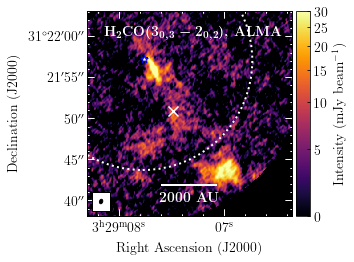

In [97]:
saveaction = 1
folder = 'ALMA/'
filename = folder+'Per50_H2COa_natural_noSC_clean_mom0_total'


savefile = filename + '_'+stretch + '.pdf'
vmin = 0
vmax = 30
vmid = 6
cmap = 'inferno'
title = r'\textbf{H\boldmath$_{2}$CO($3_{0,3}-2_{0,2}$), ALMA}'
stretch='arcsinh'

headercube = fits.getheader(filename+'.fits')
freq = headercube['RESTFRQ'] * u.Hz
phasecent = [headercube['obsra'], headercube['obsdec']]
wcscel = WCS(headercube).celestial
new_header = wcscel.to_header()
new_header['bmaj'] = headercube['bmaj']
new_header['bmin'] = headercube['bmin']
new_header['bpa'] = headercube['bpa']
new_hdu = fits.PrimaryHDU(data=fits.getdata(filename+'.fits')*1000,header=new_header)
fig = plot_aplpy_standard(new_hdu, stretch, vmin, vmax, cmap, label_col='w', star_col='b', vmid=vmid)
fig.colorbar.set_axis_label_text(r'Intensity (mJy beam$^{-1}$)')
fig.show_circles(phasecent[0], phasecent[1], ((26.7*u.arcsec).to(u.deg)*0.5).value, ls=':', color='w', lw=2)
fig.add_label(0.95,0.9, title, color='w',
               relative=True, horizontalalignment='right', size=14)
# fig.add_label(0.95,0.80, cleanalg, color='k',
#                relative=True, horizontalalignment='right', size=18)
fig.recenter(52.2805271, 31.3640439, (12.5*u.arcsec).to(u.deg).value)
fig.scalebar.set_label(r'\textbf{2000 AU}')
fig.set_nan_color('k')
plotpoint = [52.2811874,31.3641355]
fig.show_markers(plotpoint[0],plotpoint[1], c='w', s=100, marker='x')

if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)

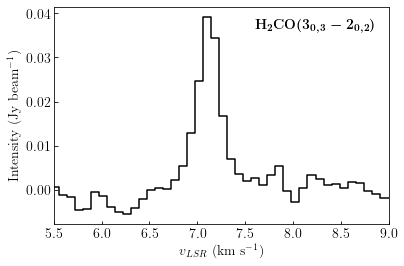

In [96]:
saveaction = 1
folder = 'ALMA/'
filename = folder+'Per50_H2COa_natural_noSC_clean'
cube = SpectralCube.read(filename+'.fits').with_spectral_unit(u.km/u.s, velocity_convention='radio')
wcscel = cube.wcs.celestial
x, y = wcscel.all_world2pix([52.2811874],[31.3641355],0)
spectra = cube[:,int(y[0]),int(x[0])]
vel = cube.spectral_axis.value

savefile = filename+'_sample_spectra.pdf'

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.plot(vel,spectra,drawstyle='steps-mid', color='k')
ax.set_xlabel(r'$v_{LSR}$ (km s$^{-1}$)')
ax.set_ylabel(r'Intensity (Jy beam$^{-1}$)')
ax.set_xlim([5.5,9])
ax.annotate(r'\textbf{H\boldmath$_{2}$CO($3_{0,3}-2_{0,2}$)}',(0.6,0.9), xycoords='axes fraction', color='k', size=14)

if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)